In [66]:
import pandas as pd
import numpy as np
import math
import os
import geopandas as gpd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from datetime import datetime
from shapely.geometry import Point
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch
import torch.optim as optim
import pyarrow
import seaborn as sns
from haversine import haversine
import contextily as ctx
import sys
import utm
import pytorch_lightning as pl
import eq
from eq.data import Sequence
from eq.data import Batch
from eq.models.space_etas import ST_ETAS
from sklearn.neighbors import KernelDensity
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# 1. Load AFAD CSV
df = pd.read_csv("data_AFAD.csv")

# 2. Keep relevant columns
cols = ["EventID", "Date", "Latitude", "Longitude", "Depth", "Magnitude", "Type"]
df = df[cols].dropna(subset=cols)

# 3. Convert date to UTC
df["Datetime"] = pd.to_datetime(df["Date"], dayfirst=True, utc=True, errors="coerce")
df.drop(columns=["Date"], inplace=True)

# 4. Buffer Turkey boundary correctly (1 km in metric CRS)
turkey = gpd.read_file("gadm41_TUR_shp/gadm41_TUR_1.shp").to_crs(4326)
turkey_m = turkey.to_crs(3857)
turkey_m["geometry"] = turkey_m.buffer(1000)  # 1 km
turkey_buffered = turkey_m.to_crs(4326)

# 5. Keep only events inside buffered Turkey
gdf_tr_all = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326"
).sjoin(turkey_buffered, how="inner", predicate="within")

# 6. Clean and filter
gdf_tr_all.rename(columns={"EventID": "Id", "Type": "Magtype"}, inplace=True)
gdf_tr_all = gdf_tr_all.drop_duplicates(subset=["Datetime", "Latitude", "Longitude", "Magnitude"])
gdf_tr_all = gdf_tr_all[(gdf_tr_all["Datetime"].dt.year >= 1990) & (gdf_tr_all["Datetime"].dt.year <= 2025)].reset_index(drop=True)

# 7. Save outputs
gdf_tr_all.to_file("turkey_catalog_clean.geojson", driver="GeoJSON")
gdf_tr_all[["Datetime", "Latitude", "Longitude", "Depth", "Magnitude"]].to_csv(
    "turkey_catalog_1990_2025.csv", index=False
)

print(f"Final Turkey catalog: {len(gdf_tr_all):,} events (1990–2025, within 10 km buffered boundary).")

# Sanity check area
turkey_eq = turkey_buffered.to_crs(6933)
print(f"Buffered Turkey area ≈ {turkey_eq.area.sum()/1e6:,.0f} km²")


Final Turkey catalog: 148,955 events (1990–2025, within 10 km buffered boundary).
Buffered Turkey area ≈ 814,359 km²


In [3]:
M = np.array(gdf_tr_all["Magnitude"])

def AEReLU_torch(M, Mc, beta):
    """
    Computes effective magnitude using AEReLU function.
    M : array or tensor of magnitudes
    Mc : completeness magnitude
    beta : sharpness for AEReLU
    """
    # Handle both numpy arrays and torch tensors
    if isinstance(M, np.ndarray):
        M_tensor = torch.from_numpy(M).float()
    else:
        M_tensor = M.float()

    softplus = nn.Softplus()
    x = softplus(beta * (M_tensor - Mc))
    M_eff = Mc + (1.0 / beta) * x

    return M_eff

In [4]:
def gr_equation(M, a, b, Mc, beta, use_aerelu=True):
    """
    Compute predicted log10 N(>=M) using Gutenberg Richter law.
    M : array or tensor of magnitudes
    a : intercept parameter
    b : slope parameter
    Mc : completeness magnitude
    beta : sharpness for AEReLU
    use_aerelu : bool, whether to use AEReLU or raw M
    """
    if use_aerelu == True:
        M_eff = AEReLU_torch(M, Mc, beta)
    else:
        M = torch.from_numpy(M)
        M_eff = M

    log10_N = a - b * M_eff

    return log10_N 

In [5]:
def empirical_ccdf(M, bins=50):
    """
    Build empirical complementary cumulative distribution (N>=M).
    
    M : numpy array of observed magnitudes
    bins : number of M points to evaluate
    
    Returns:
    M_grid : numpy array of magnitude thresholds
    counts : numpy array of event counts >= M
    logN : numpy array of log10 counts
    """
    M_grid = np.linspace(M.min(), M.max(), bins)

    counts = []
    
    for m in M_grid:
        count = np.sum(M >= m)
        counts.append(count)
    
    counts = np.array(counts)
    logN = np.log10(counts, where=counts>0)

    return M_grid, counts, logN

In [6]:
def plot_empirical_vs_model(M, a, b, Mc, beta, bins=50, use_aerelu=True):
    """
    Plot the observed earthquake frequency–magnitude distribution (empirical CCDF)
    against the predicted Gutenberg–Richter model (classic or AEReLU).

    M : Observed earthquake magnitudes.
    a, b : Gutenberg Richter intercept and slope parameters.
    Mc : Completeness magnitude for AEReLU.
    beta : Sharpness parameter for AEReLU.
    bins :  Number of magnitude thresholds for empirical CCDF (default=50).
    use_aerelu : If True, use AEReLU-adjusted GR; if False, use classic GR.
    """
    
    M_grid, counts, logN = empirical_ccdf(M, bins = bins)
    log10_N = gr_equation(M_grid, a, b, Mc, beta, use_aerelu = use_aerelu)
    log10_N = np.array(log10_N.detach().numpy() if torch.is_tensor(log10_N) else log10_N)
    
    plt.figure()
    plt.scatter(M_grid, logN, label="Empirical", s=20)
    plt.plot(M_grid, log10_N, label="Model", color="orange")
    plt.axvline(Mc, linestyle=":", color="gray", label=f"Mc={Mc:.2f}")
    plt.xlabel("Magnitude")
    plt.ylabel("log10 N(>=M)")
    plt.title("Empirical vs GR Model")
    plt.legend()
    plt.show()

In [7]:
def fit_gr_model(a, b, beta, M, Mc, bins, epochs, lr, deltaM=0.1):

    # Step 1: empirical CCDF
    M_grid, counts, logN_emp = empirical_ccdf(M, bins)
    M_grid_t = torch.tensor(M_grid, dtype=torch.float32)
    logN_emp = torch.tensor(logN_emp, dtype=torch.float32)

    # Step 2: define model
    class AEReLU_param(nn.Module):
        def __init__(self, a_init, b_init, Mc_init, beta_init):
            super().__init__()
            self.a = nn.Parameter(torch.tensor(a_init, dtype=torch.float32))
            self.b = nn.Parameter(torch.tensor(b_init, dtype=torch.float32))
            self.Mc = nn.Parameter(torch.tensor(Mc_init, dtype=torch.float32))
            self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32))
    
        def forward(self, M_grid):
            return gr_equation(M_grid, self.a, self.b, self.Mc, self.beta, use_aerelu=True)

    # Step 3: instantiate model with initial guesses
    model = AEReLU_param(a, b, Mc, beta)
    print("Initial Model Parameters:", list(model.parameters()))

    # Step 4: loss function + optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Step 5: training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        logN_pred = model(M_grid_t)       
        loss = loss_fn(logN_pred, logN_emp)  
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, "
                  f"a={model.a.item():.3f}, b={model.b.item():.3f}, "
                  f"Mc={model.Mc.item():.3f}, beta={model.beta.item():.3f}")

    fitted_a = model.a.item()
    fitted_Mc = model.Mc.item()
    fitted_beta = model.beta.item()

    # Step 6: compute MLE b-value (Aki 1965)
    M_above_Mc = M[M >= fitted_Mc]
    if len(M_above_Mc) == 0:
        raise ValueError("No magnitudes above Mc for MLE calculation")

    mean_M = M_above_Mc.mean()
    b_mle = (np.log10(np.e)) / (mean_M - (fitted_Mc - deltaM/2))

    print("\nFinal Parameters:")
    print(f"a={fitted_a:.3f}, Mc={fitted_Mc:.3f}, beta={fitted_beta:.3f}, b_MLE={b_mle:.3f}")

    return fitted_a, b_mle, fitted_Mc, fitted_beta, loss.item()

In [8]:
def gardner_knopoff(df, time_window_func, dist_window_func):
    """
    Decluster using Gardner & Knopoff (1974) windows.
    df must have: Datetime, Latitude, Longitude, Mw
    """
    df = df.sort_values("Datetime").reset_index(drop=True)
    is_mainshock = np.ones(len(df), dtype=bool)

    for i, row in df.iterrows():
        if not is_mainshock[i]:
            continue  # skip if already flagged as aftershock
        mw = row["Magnitude"]
        t_win = time_window_func(mw)
        d_win = dist_window_func(mw)
        t0 = row["Datetime"]

        for j in range(i+1, len(df)):
            dt = (df.loc[j, "Datetime"] - t0).days
            if dt > t_win:
                break  # stop if beyond time window
            dist = haversine((row["Latitude"], row["Longitude"]),
                             (df.loc[j, "Latitude"], df.loc[j, "Longitude"]))
            if dist <= d_win:
                is_mainshock[j] = False

    return df[is_mainshock]

# Example window functions from GK74 (approximate)
def time_window(mw): 
    return 10 ** (0.032 * mw + 2.738) / 1440  # days

def dist_window(mw): 
    return 10 ** (0.1238 * mw + 0.983)  # km

In [9]:
# Run declustering
gdf_declust = gardner_knopoff(gdf_tr_all, time_window, dist_window)

print("Original catalog size:", len(gdf_tr_all))
print("Declustered catalog size:", len(gdf_declust))


Original catalog size: 148955
Declustered catalog size: 84850


In [10]:
# --- Prepare Data ---
M = np.array(gdf_declust["Magnitude"])  # Use AFAD native magnitude directly

# Initial parameter guesses (you can tune these as before)
a0, b0, beta0 = 7.5, 1.0, 5.0
mc_starts = [2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]

results = []

# --- Run AEReLU for each Mc starting point ---
for mc0 in mc_starts:
    print(f"\n--- Running AEReLU with Mc0 = {mc0} ---")
    a_fit, b_fit, Mc_fit, beta_fit, loss_fit = fit_gr_model(
        a0, b0, beta0, M, mc0,
        bins=50, epochs=300, lr=0.001, deltaM=0.1
    )
    results.append((mc0, a_fit, b_fit, Mc_fit, beta_fit, loss_fit))

# --- Convert results to DataFrame ---
cols = ["Mc_init", "a_value", "b_value", "Mc_est", "beta", "loss"]
results_df = pd.DataFrame(results, columns=cols)

# --- Display ---
print("\nAEReLU Results:")
display(results_df)


--- Running AEReLU with Mc0 = 2.4 ---
Initial Model Parameters: [Parameter containing:
tensor(7.5000, requires_grad=True), Parameter containing:
tensor(1., requires_grad=True), Parameter containing:
tensor(2.4000, requires_grad=True), Parameter containing:
tensor(5., requires_grad=True)]
Epoch 0, Loss: 0.1644, a=7.499, b=1.001, Mc=2.401, beta=4.999
Epoch 10, Loss: 0.1341, a=7.489, b=1.011, Mc=2.411, beta=4.989
Epoch 20, Loss: 0.1123, a=7.480, b=1.020, Mc=2.420, beta=4.980
Epoch 30, Loss: 0.0985, a=7.471, b=1.028, Mc=2.429, beta=4.971
Epoch 40, Loss: 0.0911, a=7.464, b=1.035, Mc=2.436, beta=4.963
Epoch 50, Loss: 0.0878, a=7.457, b=1.039, Mc=2.441, beta=4.957
Epoch 60, Loss: 0.0866, a=7.452, b=1.042, Mc=2.445, beta=4.952
Epoch 70, Loss: 0.0862, a=7.448, b=1.043, Mc=2.447, beta=4.947
Epoch 80, Loss: 0.0858, a=7.445, b=1.044, Mc=2.448, beta=4.944
Epoch 90, Loss: 0.0855, a=7.442, b=1.043, Mc=2.448, beta=4.941
Epoch 100, Loss: 0.0852, a=7.439, b=1.042, Mc=2.448, beta=4.938
Epoch 110, Loss: 

Mc_init   a_value   b_value    Mc_est      beta      loss
0      2.4  7.355066  0.868884  2.398349  4.901185  0.076762
1      2.6  7.351779  0.817791  2.412300  4.960391  0.076511
2      2.8  7.355992  0.933361  2.529312  5.126058  0.078162
3      3.0  7.370470  1.030327  2.722232  5.165228  0.086082
4      3.2  7.395427  1.016227  2.919838  5.063847  0.102600
5      3.4  7.443308  0.936051  3.120128  4.861458  0.129361
6      3.6  7.542176  0.899037  3.322485  4.743446  0.166543
7      3.8  7.678652  0.893580  3.524426  4.699573  0.212659
8      4.0  7.739141  0.907258  3.722020  4.693587  0.268427

In [11]:
results_df = pd.DataFrame(
    results,
    columns=["Mc_start", "a_value", "b_value", "Mc_final", "beta", "Loss"]
)

styled_results = (
    results_df.style
    .format({
        "Mc_start": "{:.1f}",
        "a_value": "{:.3f}",
        "b_value": "{:.3f}",
        "Mc_final": "{:.3f}",
        "beta": "{:.3f}",
        "Loss": "{:.3f}"
    })
    .background_gradient(subset=["b_value"], cmap="Greens")
    .background_gradient(subset=["Loss"], cmap="RdYlGn_r")
    .set_table_styles([{
        "selector": "th",
        "props": [("font-weight", "bold"), ("text-align", "center")]
    }])
)

styled_results


In [12]:
events_check = gdf_tr_all[
    (gdf_tr_all["Magnitude"] > 6.0)
    & (gdf_tr_all["Datetime"].dt.year.isin([1992, 1999, 2011, 2023]))
].sort_values(["Datetime", "Magnitude"], ascending=[True, False])

events_check[["Datetime", "Magnitude", "Magtype", "Latitude", "Longitude"]].head(15)

Datetime  Magnitude Magtype  Latitude  Longitude
148234 1992-03-13 17:18:41+00:00        7.0      Md    40.000    40.0000
148209 1992-03-15 16:16:26+00:00        6.1      Md    39.600    39.8000
145747 1999-08-17 01:01:39+00:00        7.4      Md    40.700    29.9100
145024 1999-11-12 16:57:21+00:00        7.2      Md    40.790    31.2100
79281  2011-10-23 11:41:20+00:00        6.7      Ml    38.689    43.4657
28116  2023-02-06 01:17:32+00:00        7.7      MW    37.288    37.0430
28113  2023-02-06 01:28:16+00:00        6.6      MW    37.304    36.9200
27878  2023-02-06 10:24:47+00:00        7.6      MW    38.089    37.2390
21926  2023-02-20 17:04:27+00:00        6.4      MW    36.037    36.0210

In [13]:
gdf_tr = gdf_tr_all[
    (gdf_tr_all["Magnitude"] >= 2.8) &
    (gdf_tr_all["Datetime"].dt.year >= 1990) &
    (gdf_tr_all["Datetime"].dt.year <= 2025)
].copy()

gdf_tr.describe()

Id      Latitude     Longitude         Depth     Magnitude  \
count   56031.000000  56031.000000  56031.000000  56031.000000  56031.000000   
mean   243719.866074     38.718337     34.197207      8.870626      3.119939   
std    167099.142807      1.165819      5.187590      6.397945      0.388790   
min     50519.000000     35.837800     25.686300      0.000000      2.800000   
25%     95558.000000     37.870000     29.180000      6.840000      2.900000   
50%    239182.000000     38.688700     34.427600      7.010000      3.000000   
75%    266741.500000     39.567550     38.486700     10.190000      3.200000   
max    673342.000000     42.000000     44.794700    135.410000      7.700000   

        index_right  
count  56031.000000  
mean      36.274616  
std       22.454239  
min        0.000000  
25%       20.000000  
50%       36.000000  
75%       54.000000  
max       80.000000

In [14]:
print(gdf_tr.dtypes)

Id                           int64
Latitude                   float64
Longitude                  float64
Depth                      float64
Magnitude                  float64
Magtype                     object
Datetime       datetime64[ns, UTC]
geometry                  geometry
index_right                  int64
GID_1                       object
GID_0                       object
COUNTRY                     object
NAME_1                      object
VARNAME_1                   object
NL_NAME_1                   object
TYPE_1                      object
ENGTYPE_1                   object
CC_1                        object
HASC_1                      object
ISO_1                       object
dtype: object


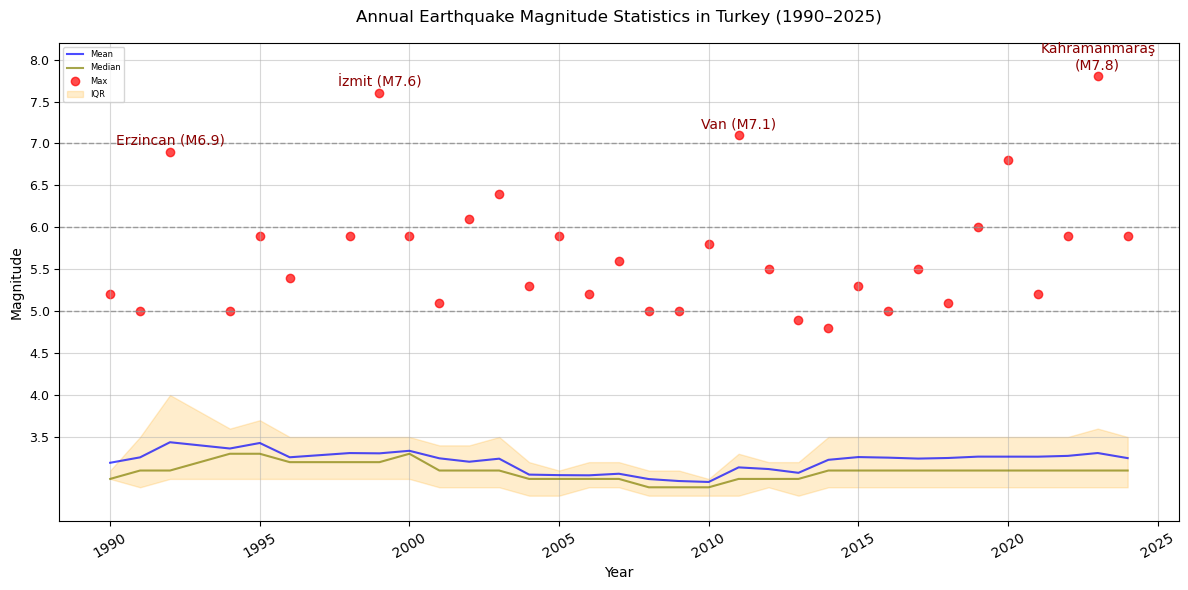

In [15]:
mag_mean = (
    gdf_tr.groupby(gdf_tr["Datetime"].dt.year)
    .agg(
        Mean=("Magnitude", "mean"),
        Q1=("Magnitude", lambda x: x.quantile(0.25)),
        Median=("Magnitude", "median"),
        Q3=("Magnitude", lambda x: x.quantile(0.75)),
        Max=("Magnitude", "max")
    )
)

# Apply manual Mw corrections for known major events
mw_corrections = {
    1992: 6.9,   # Erzincan
    1999: 7.6,   # İzmit
    2011: 7.1,   # Van
    2023: 7.8    # Kahramanmaraş
}

for year, mw in mw_corrections.items():
    if year in mag_mean.index:
        mag_mean.loc[year, "Max"] = mw

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xticks([1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025])
ax.set_yticks([3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0])
ax.set_ylim(2.5, 8.2)
ax.tick_params(axis="x", rotation=30)
ax.tick_params(axis="y", labelsize=9)

ax.plot(mag_mean.index, mag_mean["Mean"], alpha=0.7, color="blue", label="Mean")
ax.plot(mag_mean.index, mag_mean["Median"], alpha=0.7, color="olive", label="Median")
plt.scatter(mag_mean.index, mag_mean["Max"], alpha=0.7, color="red", label="Max")
plt.fill_between(mag_mean.index, mag_mean["Q1"], mag_mean["Q3"],
                 color="orange", alpha=0.2, label="IQR")

labels = {
    1992: "Erzincan (M6.9)",
    1999: "İzmit (M7.6)",
    2011: "Van (M7.1)",
    2023: "Kahramanmaraş\n(M7.8)"
}

for year, label in labels.items():
    if year in mag_mean.index:
        plt.annotate(
            label,
            (year, mag_mean.loc[year, "Max"]),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            fontsize=10,
            color='darkred'
        )

for threshold in [5, 6, 7]:
    ax.axhline(y=threshold, color="grey", lw=1, ls="--", alpha=0.7)

plt.xlabel("Year", fontsize=10)
plt.ylabel("Magnitude", fontsize=10)
plt.title("Annual Earthquake Magnitude Statistics in Turkey (1990–2025)", fontsize=12, pad=15)

plt.legend(fontsize=6)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()



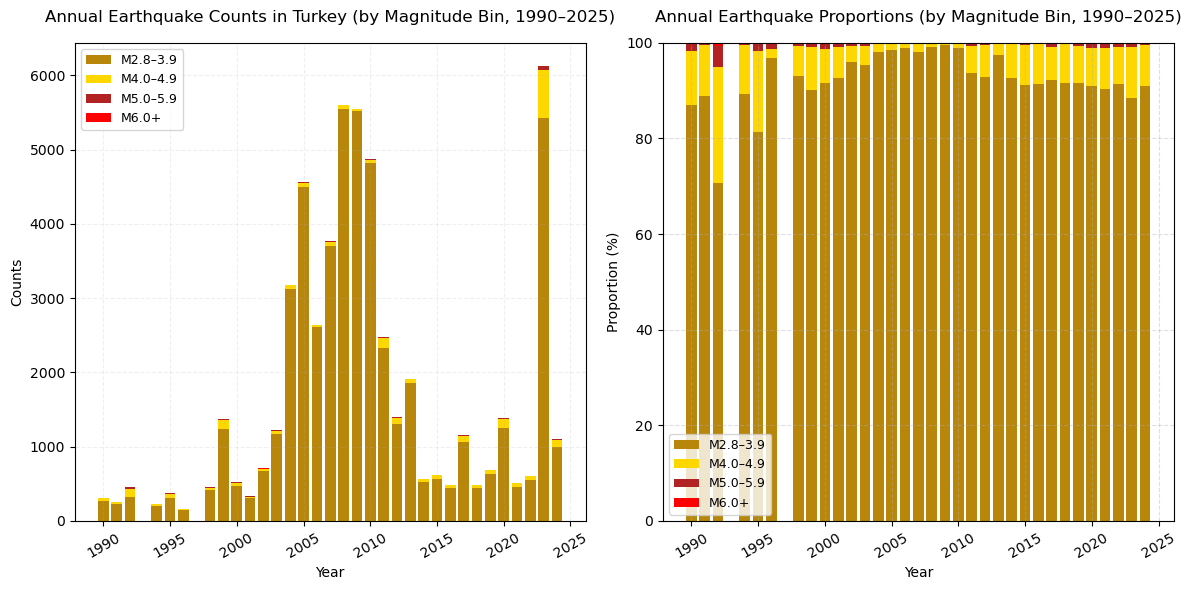

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

gdf_tr["Mag_Bin"] = pd.cut(
    gdf_tr["Magnitude"],
    bins=[2.8, 4.0, 5.0, 6.0, float("inf")],
    labels=["2.8–3.9", "4.0–4.9", "5.0–5.9", "6.0+"],
    right=False
)

counts = gdf_tr.groupby([gdf_tr["Datetime"].dt.year, gdf_tr["Mag_Bin"]], observed=True).size()
counts_unstacked = counts.unstack(fill_value=0)

y1 = counts_unstacked["2.8–3.9"]
y2 = counts_unstacked["4.0–4.9"]
y3 = counts_unstacked["5.0–5.9"]
y4 = counts_unstacked["6.0+"]

ax1.bar(counts_unstacked.index, y1, color="darkgoldenrod", label="M2.8–3.9")
ax1.bar(counts_unstacked.index, y2, bottom=y1, color="gold", label="M4.0–4.9")
ax1.bar(counts_unstacked.index, y3, bottom=y1 + y2, color="firebrick", label="M5.0–5.9")
ax1.bar(counts_unstacked.index, y4, bottom=y1 + y2 + y3, color="red", label="M6.0+")

ax1.set_xticks([1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025])
ax1.tick_params(axis="x", rotation=30)
ax1.set_xlabel("Year", fontsize=10)
ax1.set_ylabel("Counts", fontsize=10)
ax1.set_title("Annual Earthquake Counts in Turkey (by Magnitude Bin, 1990–2025)", fontsize=12, pad=15)
ax1.legend(fontsize=9)
ax1.grid(linestyle="--", alpha=0.2)

row_totals = counts_unstacked.sum(axis=1)
counts_prop = counts_unstacked.div(row_totals, axis=0) * 100

y1_b = counts_prop["2.8–3.9"]
y2_b = counts_prop["4.0–4.9"]
y3_b = counts_prop["5.0–5.9"]
y4_b = counts_prop["6.0+"]

ax2.bar(counts_prop.index, y1_b, color="darkgoldenrod", label="M2.8–3.9")
ax2.bar(counts_prop.index, y2_b, bottom=y1_b, color="gold", label="M4.0–4.9")
ax2.bar(counts_prop.index, y3_b, bottom=y1_b + y2_b, color="firebrick", label="M5.0–5.9")
ax2.bar(counts_prop.index, y4_b, bottom=y1_b + y2_b + y3_b, color="red", label="M6.0+")

ax2.set_xticks([1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025])
ax2.tick_params(axis="x", rotation=30)
ax2.set_xlabel("Year", fontsize=10)
ax2.set_ylabel("Proportion (%)", fontsize=10)
ax2.set_ylim(0, 100)
ax2.set_title("Annual Earthquake Proportions (by Magnitude Bin, 1990–2025)", fontsize=12, pad=15)
ax2.legend(fontsize=9)
ax2.grid(linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()



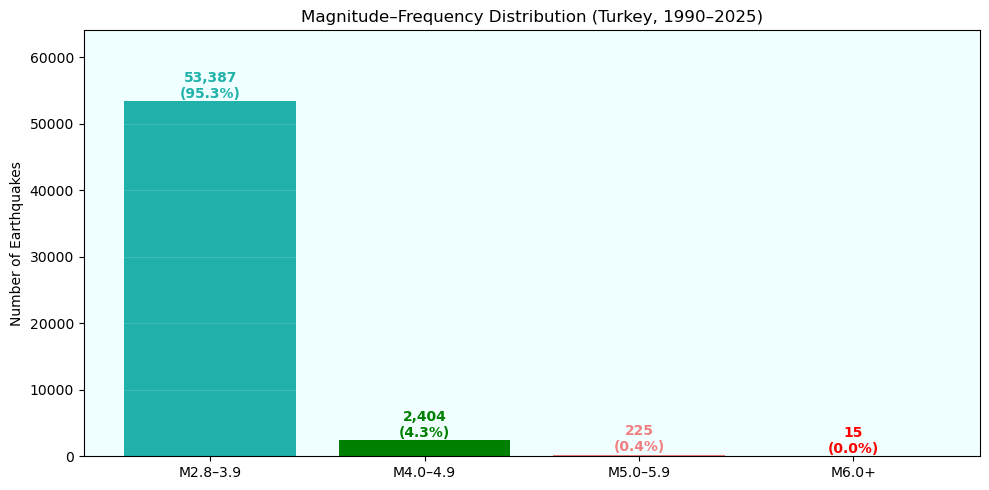

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

gdf_tr["Mag_Bin"] = pd.cut(
    gdf_tr["Magnitude"],
    bins=[2.8, 4.0, 5.0, 6.0, float("inf")],
    labels=["M2.8–3.9", "M4.0–4.9", "M5.0–5.9", "M6.0+"],
    right=False
)

bin1 = (gdf_tr["Mag_Bin"] == "M2.8–3.9").sum()
bin2 = (gdf_tr["Mag_Bin"] == "M4.0–4.9").sum()
bin3 = (gdf_tr["Mag_Bin"] == "M5.0–5.9").sum()
bin4 = (gdf_tr["Mag_Bin"] == "M6.0+").sum()

bars = ax.bar(
    ["M2.8–3.9", "M4.0–4.9", "M5.0–5.9", "M6.0+"],
    (bin1, bin2, bin3, bin4),
    color=("lightseagreen", "green", "lightcoral", "red")
)

total = bin1 + bin2 + bin3 + bin4
for bar in bars:
    height = bar.get_height()
    percentage = (height / total) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + (total * 0.001),
        f"{int(height):,}\n({percentage:.1f}%)",
        ha="center", va="bottom",
        fontweight="bold",
        color=bar.get_facecolor()
    )

ax.set_ylabel("Number of Earthquakes")
ax.set_title("Magnitude–Frequency Distribution (Turkey, 1990–2025)")
ax.set_facecolor("azure")
ax.yaxis.grid(True, alpha=0.2, linestyle="-", linewidth=0.5, color="white")
ax.set_ylim(0, max(bin1, bin2, bin3, bin4) * 1.2)

fig.tight_layout()
plt.show()


In [18]:
#This project uses the 
#Aki–Utsu maximum-likelihood method for b-value estimation,
#adapted from ANU’s EMSC-2022 Lab 8 materials


def fmd_values(dataset, start=1990, end=2025, bin_width=0.1, threshold=None):
    """
    Compute a-value, b-value, b-value standard deviation, and N
    using Aki–Utsu maximum likelihood method for a given year range.
    """
    # Filter by year range
    mask = (dataset["Datetime"].dt.year 
            >= start) & (dataset["Datetime"].dt.year < end)
    dataset = dataset.loc[mask].copy()
    
    magnitudes = dataset["Magnitude"].to_numpy()
    if threshold is not None:
        magnitudes = magnitudes[magnitudes >= threshold]
    
    length = magnitudes.shape[0]
    if length <= 1:
        return np.nan, np.nan, np.nan, length
    
    minimum = magnitudes.min()
    average = magnitudes.mean()

    # Aki–Utsu MLE
    b_value = (np.log10(np.e)) / (average - (minimum - bin_width / 2))
    variance = np.sum((magnitudes - average) ** 2) / (length * (length - 1))
    b_stddev = 2.3 * (b_value ** 2) * np.sqrt(variance)
    a_value = np.log10(length) + b_value * minimum

    return a_value, b_value, b_stddev, length

In [19]:

periods = [ 
    (1990, 2000),   
    (2000, 2005),
    (2005, 2010),
    (2010, 2015),
    (2015, 2020),
    (2020, 2025) 
]

threshold = 2.8

results = []

for (s, e) in periods:
    a, b, bstd, n = fmd_values(gdf_tr, start=s, end=e, threshold=threshold)
    results.append({
        "start": s,
        "end": e,
        "threshold": threshold,
        "a_value": a,
        "b_value": b,
        "b_std": bstd,
        "N": n
    })

fmd_values_results = pd.DataFrame(results)
print(fmd_values_results.round(3))



   start   end  threshold  a_value  b_value  b_std      N
0   1990  2000        2.8    5.677    0.757  0.011   3600
1   2000  2005        2.8    6.861    1.102  0.014   5959
2   2005  2010        2.8    8.878    1.619  0.011  22110
3   2010  2015        2.8    8.061    1.433  0.016  11217
4   2015  2020        2.8    5.952    0.864  0.013   3422
5   2020  2025        2.8    6.234    0.802  0.007   9723


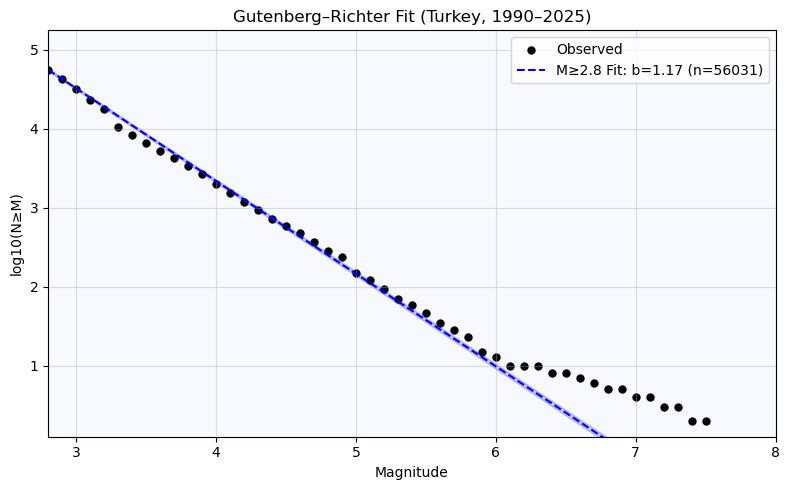

In [20]:
a, b, bstd, n = fmd_values(gdf_tr, start=1990, end=2025, threshold=2.8)

magnitudes = gdf_tr["Magnitude"]
unique_mags = np.arange(magnitudes.min(), magnitudes.max(), 0.1)
cumulative_counts = [np.sum(magnitudes >= m) for m in unique_mags]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(unique_mags, np.log10(cumulative_counts),
           label="Observed", color="black", s=25)

y_fit = a - b * unique_mags
y_upper = a - (b - bstd) * unique_mags
y_lower = a - (b + bstd) * unique_mags
ax.plot(unique_mags, y_fit, color="blue", linestyle="--",
        label=f"M≥2.8 Fit: b={b:.2f} (n={n})")
ax.fill_between(unique_mags, y_lower, y_upper, color="blue", alpha=0.2)

ax.set_xlabel("Magnitude")
ax.set_ylabel("log10(N≥M)")
ax.set_xlim(2.8, 8.0)
ax.set_ylim(0.1, np.log10(len(magnitudes)) + 0.5)
ax.set_title("Gutenberg–Richter Fit (Turkey, 1990–2025)")
ax.set_facecolor("ghostwhite")
ax.grid(alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()



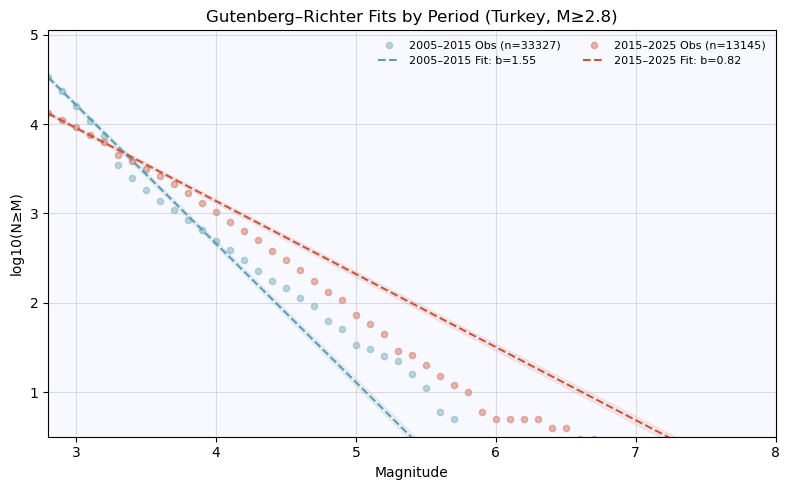

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

periods = [
    (2005, 2015, "#5C9EAD"),
    (2015, 2025, "#C8553D")
]

threshold = 2.8

for s, e, color in periods:
    a, b, bstd, n = fmd_values(gdf_tr, start=s, end=e, threshold=threshold)
    
    mask = (gdf_tr["Datetime"].dt.year >= s) & (gdf_tr["Datetime"].dt.year < e)
    mags = gdf_tr.loc[mask, "Magnitude"].to_numpy()
    mags = mags[mags >= threshold]
    if len(mags) == 0:
        continue

    unique_mags = np.arange(mags.min(), mags.max(), 0.1)
    cumulative_counts = [np.sum(mags >= m) for m in unique_mags]

    y_fit = a - b * unique_mags
    y_upper = a - (b - bstd) * unique_mags
    y_lower = a - (b + bstd) * unique_mags

    ax.scatter(unique_mags, np.log10(cumulative_counts),
               color=color, s=20, alpha=0.4, label=f"{s}–{e} Obs (n={n})")
    ax.plot(unique_mags, y_fit, color=color, linestyle="--",
            label=f"{s}–{e} Fit: b={b:.2f}")
    ax.fill_between(unique_mags, y_lower, y_upper, color=color, alpha=0.1)

ax.set_xlabel("Magnitude")
ax.set_ylabel("log10(N≥M)")
ax.set_xlim(2.8, 8.0)
ax.set_ylim(0.5, np.log10(len(gdf_tr)) + 0.3)
ax.set_title("Gutenberg–Richter Fits by Period (Turkey, M≥2.8)")
ax.set_facecolor("ghostwhite")
ax.grid(alpha=0.4)
ax.legend(fontsize=8, loc="upper right", ncol=2, frameon=False)
plt.tight_layout()
plt.show()





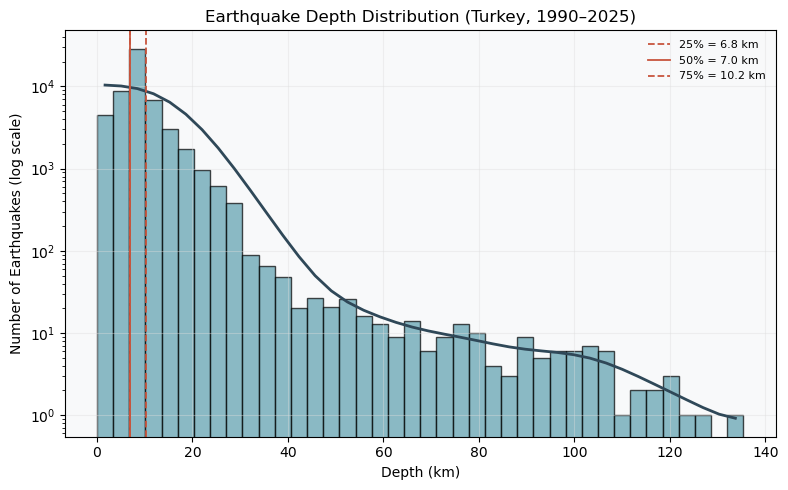

In [22]:
depths = gdf_tr["Depth"].dropna()

fig, ax = plt.subplots(figsize=(8, 5))

counts, bins, patches = ax.hist(
    depths, bins=40, color="#5C9EAD", edgecolor="black", alpha=0.7
)

bin_centers = 0.5 * (bins[1:] + bins[:-1])
counts_smooth = gaussian_filter1d(counts, sigma=2.5)
ax.plot(bin_centers, counts_smooth, color="#2F4858", lw=2)

for q, style in zip([0.25, 0.5, 0.75], ["--", "-", "--"]):
    val = depths.quantile(q)
    ax.axvline(val, color="#C8553D", linestyle=style, lw=1.3, label=f"{int(q*100)}% = {val:.1f} km")

ax.set_xlabel("Depth (km)")
ax.set_ylabel("Number of Earthquakes (log scale)")
ax.set_title("Earthquake Depth Distribution (Turkey, 1990–2025)")
ax.set_facecolor("#f8f9fa")
ax.grid(alpha=0.4, color="#dddddd")
ax.set_yscale("log")
ax.legend(fontsize=8, frameon=False)

plt.tight_layout()
plt.show()



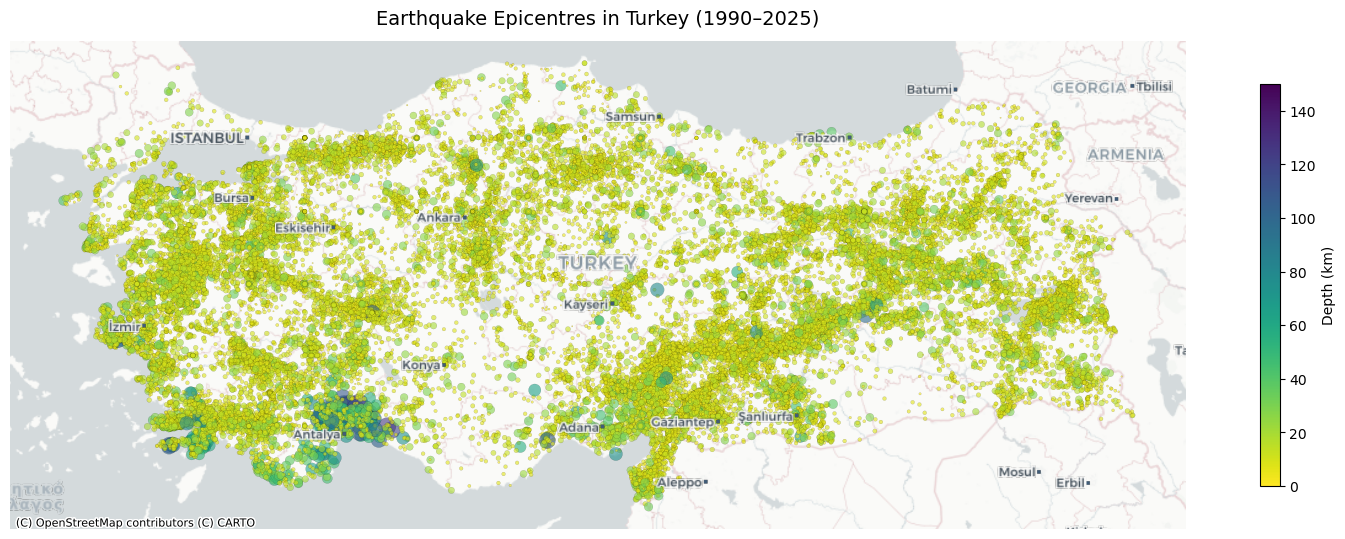

In [23]:
gdf_plot = gdf_tr.set_geometry("geometry").set_crs(epsg=4326)
gdf_web = gdf_plot.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 7))

sc = gdf_web.plot(
    ax=ax,
    column="Depth",
    cmap="viridis_r",
    vmin=0, vmax=150,
    markersize=(gdf_web["Depth"] ** 1.05),  
    alpha=0.6,
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={
        "label": "Depth (km)",
        "shrink": 0.6,
        "orientation": "vertical"
    }
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronOnlyLabels)

ax.set_axis_off()
ax.set_title("Earthquake Epicentres in Turkey (1990–2025)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()




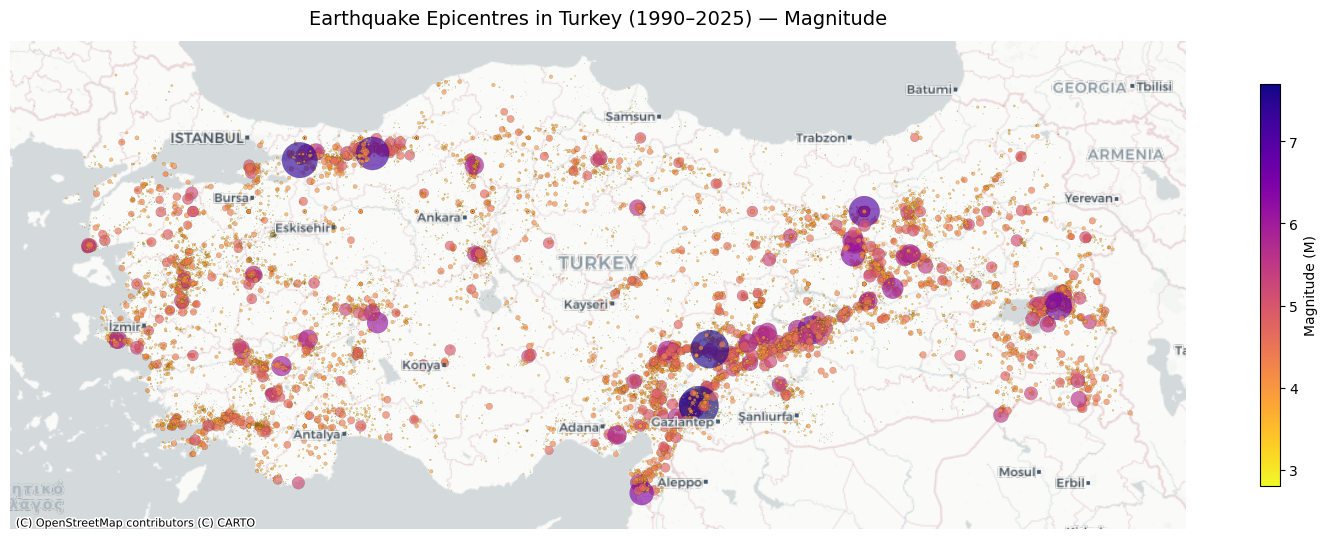

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))

# Plot earthquakes (color = Magnitude, size = Magnitude)
gdf_web.plot(
    ax=ax,
    column="Magnitude",
    cmap="plasma_r",
    vmin=gdf_web["Magnitude"].min(),
    vmax=gdf_web["Magnitude"].max(),
    markersize=(gdf_web["Magnitude"] - 2.8)**3.2 * 5, 
    alpha=0.65,
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={
        "label": "Magnitude (M)",
        "shrink": 0.6
    }
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronOnlyLabels)

ax.set_axis_off()
ax.set_title("Earthquake Epicentres in Turkey (1990–2025) — Magnitude", fontsize=14, pad=12)
plt.tight_layout()
plt.show()



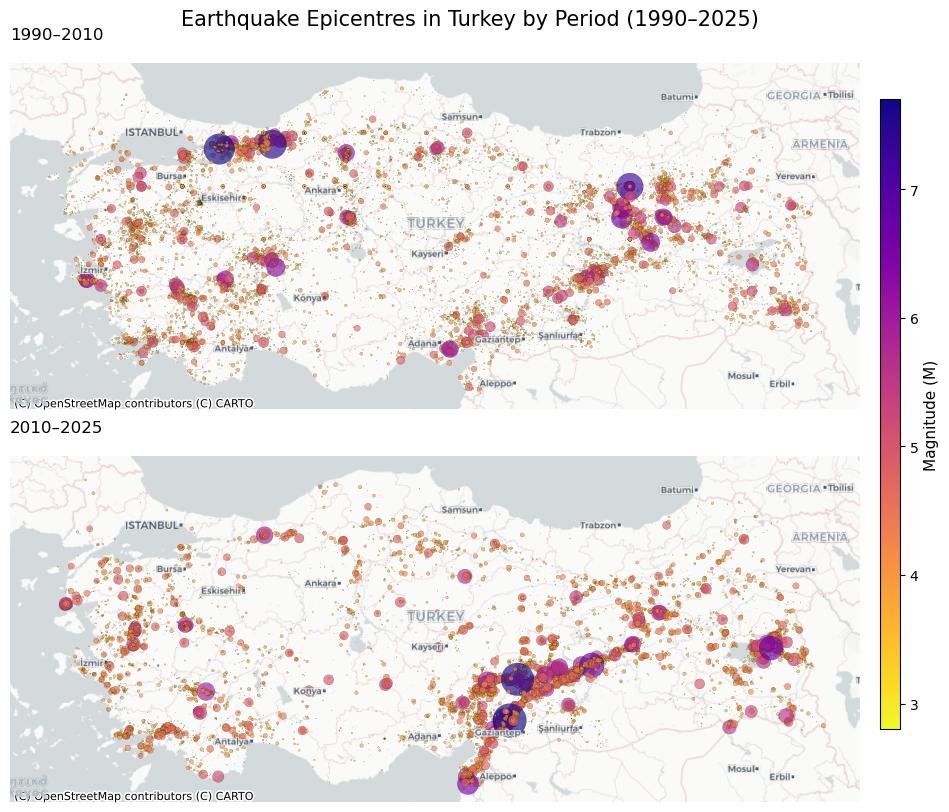

In [25]:
periods = [
    (1990, 2010, "1990–2010"),
    (2010, 2025, "2010–2025")
]

gdf_web = gdf_plot.to_crs(epsg=3857)

fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True, sharey=True)

for ax, (start, end, label) in zip(axes, periods):
    mask = (gdf_web["Datetime"].dt.year >= start) & (gdf_web["Datetime"].dt.year < end)
    subset = gdf_web.loc[mask]

    subset.plot(
        ax=ax,
        column="Magnitude",
        cmap="plasma_r",
        markersize=(subset["Magnitude"] - 2.8)**3.0 *5,
        alpha=0.65,
        edgecolor="k",
        linewidth=0.15,
        legend=False
    )

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronOnlyLabels)
    ax.set_title(label, fontsize=12, loc="left")
    ax.set_axis_off()

# Shared colorbar (dedicated inset axis)
sm = plt.cm.ScalarMappable(
    cmap="plasma_r",
    norm=plt.Normalize(vmin=gdf_web["Magnitude"].min(), vmax=gdf_web["Magnitude"].max())
)
sm._A = []
cax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Magnitude (M)", fontsize=11)

fig.suptitle("Earthquake Epicentres in Turkey by Period (1990–2025)", fontsize=15, y=0.95)
plt.subplots_adjust(top=0.91, bottom=0.05, left=0.04, right=0.89, hspace=0.03)
plt.show()



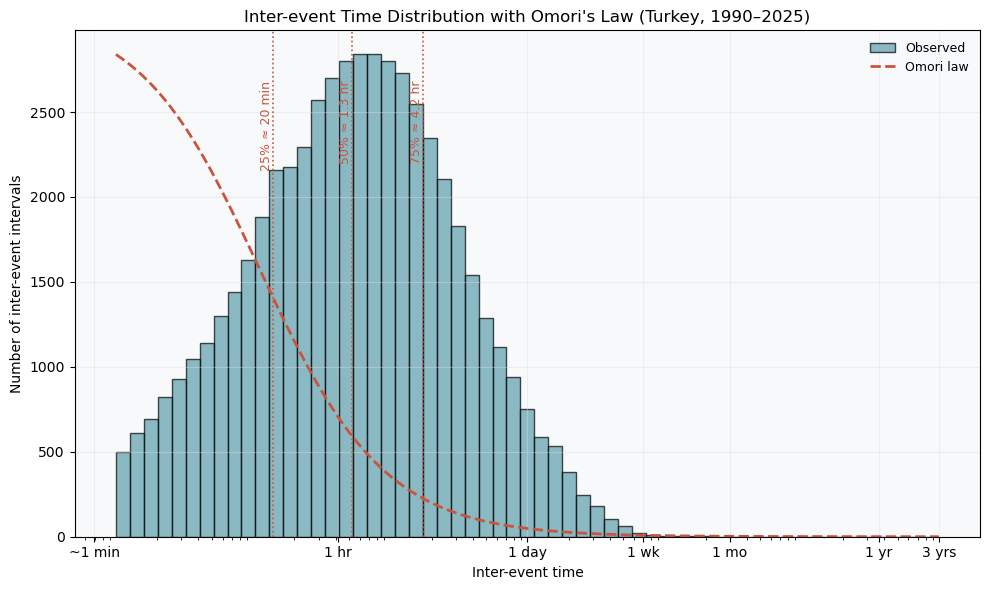

In [26]:
gdf_tr["Datetime"] = pd.to_datetime(gdf_tr["Datetime"], errors="coerce")

times = gdf_tr["Datetime"].sort_values()
deltas = times.diff().dropna()
deltas_days = deltas.dt.total_seconds() / (24 * 3600)

fig, ax = plt.subplots(figsize=(10, 6))

counts, bins, _ = ax.hist(
    deltas_days,
    bins=np.logspace(-3, 3, 60),
    color="#5C9EAD",
    alpha=0.7,
    edgecolor="k",
    label="Observed"
)

ax.set_xscale("log")
ax.set_xticks([1/24/60, 1/24, 1, 7, 30, 365, 1000])
ax.set_xticklabels(["~1 min", "1 hr", "1 day", "1 wk", "1 mo", "1 yr", "3 yrs"])

t_vals = np.logspace(-3, 3, 300)
K, c, p = 1e4, 0.01, 0.9
omori_rate = K / ((t_vals + c) ** p)
scale_factor = max(counts) / max(omori_rate)
omori_rate_scaled = omori_rate * scale_factor

ax.plot(t_vals, omori_rate_scaled, color="#C8553D", linestyle="--", lw=2, label="Omori law")

percentiles = [25, 50, 75]
perc_values = np.percentile(deltas_days, percentiles)

for p, val in zip(percentiles, perc_values):
    if val < 1/24:
        label = f"{val*24*60:.0f} min"
    elif val < 1:
        label = f"{val*24:.1f} hr"
    elif val < 7:
        label = f"{val:.1f} d"
    elif val < 30:
        label = f"{val/7:.1f} wk"
    else:
        label = f"{val/30:.1f} mo"

    ax.axvline(val, color="#C8553D", linestyle=":", lw=1.2)
    ax.text(val, ax.get_ylim()[1]*0.9, f"{p}% ≈ {label}",
            color="#C8553D", rotation=90, ha="right", va="top", fontsize=9)

ax.set_xlabel("Inter-event time")
ax.set_ylabel("Number of inter-event intervals")
ax.set_title("Inter-event Time Distribution with Omori's Law (Turkey, 1990–2025)")
ax.grid(alpha=0.4, color="#dddddd")
ax.set_facecolor("#f8f9fa")
ax.legend(fontsize=9, frameon=False)

plt.tight_layout()
plt.show()


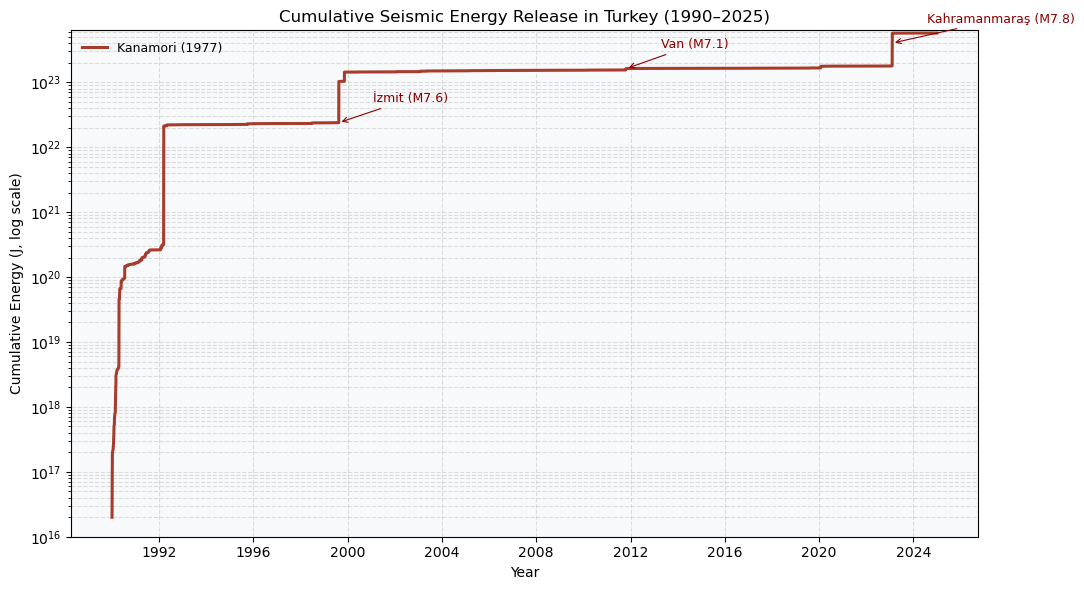

In [27]:
# Ensure datetime and magnitude are valid
gdf_tr["Datetime"] = pd.to_datetime(gdf_tr["Datetime"], errors="coerce")
gdf_tr = gdf_tr.dropna(subset=["Datetime", "Magnitude"]).copy()

# Restrict to completeness period
gdf_tr = gdf_tr[gdf_tr["Datetime"].dt.year.between(1990, 2025)]

# Calculate seismic energy using Kanamori (1977)
gdf_tr["Energy_Kanamori"] = 10 ** (11.8 + 1.5 * gdf_tr["Magnitude"])

# Sort chronologically and compute cumulative energy
gdf_tr = gdf_tr.sort_values("Datetime")
gdf_tr["CEnergy_Kanamori"] = gdf_tr["Energy_Kanamori"].cumsum()

# Plot cumulative energy release
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(
    gdf_tr["Datetime"], gdf_tr["CEnergy_Kanamori"],
    color="#A63D2C", lw=2.2, label="Kanamori (1977)"
)

# Log scale for better dynamic range visibility
ax.set_yscale("log")
ax.set_ylim(1e16, gdf_tr["CEnergy_Kanamori"].max() * 1.1)

# Axis labels and title
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Cumulative Energy (J, log scale)", fontsize=10)
ax.set_title("Cumulative Seismic Energy Release in Turkey (1990–2025)", fontsize=12)

# Annotate major earthquakes
major_eqs = {
    "1999-08-17": "İzmit (M7.6)",
    "2011-10-23": "Van (M7.1)",
    "2023-02-06": "Kahramanmaraş (M7.8)"
}
for date, label in major_eqs.items():
    d = pd.to_datetime(date)
    match = gdf_tr.loc[gdf_tr["Datetime"].dt.date == d.date()]
    if not match.empty:
        e_val = match["CEnergy_Kanamori"].values[0]
        ax.annotate(
            label, xy=(d, e_val), xytext=(25, 15),
            textcoords="offset points", fontsize=9, color="darkred",
            arrowprops=dict(arrowstyle="->", lw=0.8, color="darkred")
        )

# Grid, legend, and styling
ax.grid(alpha=0.4, which="both", linestyle="--")
ax.legend(fontsize=9, frameon=False)
ax.set_facecolor("#f8f9fa")

plt.tight_layout()
plt.show()



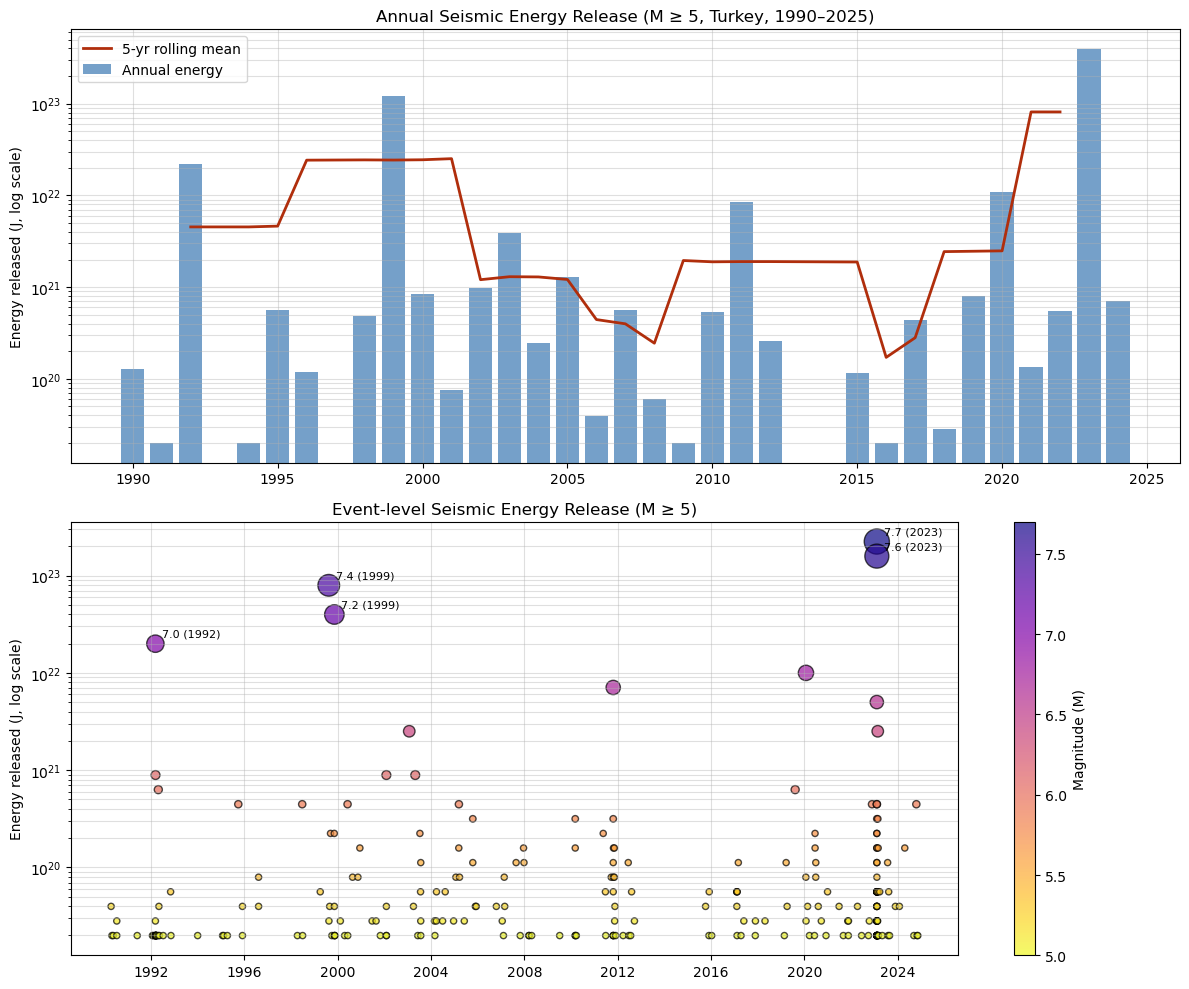

In [28]:
# Filter for M ≥ 5 events (focus on major quakes)
df_m5 = gdf_tr[gdf_tr["Magnitude"] >= 5].copy()

# Add Year column for grouping
df_m5["Year"] = df_m5["Datetime"].dt.year

# Compute annual and 5-year smoothed energy release (Kanamori)
annual_energy = df_m5.groupby("Year")["Energy_Kanamori"].sum()
rolling_mean = annual_energy.rolling(5, center=True).mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Annual energy release
ax[0].bar(annual_energy.index, annual_energy,
          color="#3A78B2", alpha=0.7, label="Annual energy")
ax[0].plot(rolling_mean.index, rolling_mean,
           color="#B02E0C", lw=2, label="5-yr rolling mean")

ax[0].set_yscale("log")
ax[0].set_ylabel("Energy released (J, log scale)")
ax[0].set_title("Annual Seismic Energy Release (M ≥ 5, Turkey, 1990–2025)")
ax[0].legend()
ax[0].grid(alpha=0.4, which="both")

# Event-level energy scatter
sc = ax[1].scatter(df_m5["Datetime"], df_m5["Energy_Kanamori"],
                   c=df_m5["Magnitude"], cmap="plasma_r",
                   s=np.maximum((df_m5["Magnitude"] - 4.5) ** 3 * 10, 20),
                   alpha=0.7, edgecolor="k")

ax[1].set_yscale("log")
ax[1].set_title("Event-level Seismic Energy Release (M ≥ 5)")
ax[1].set_ylabel("Energy released (J, log scale)")
ax[1].grid(alpha=0.4, which="both")

# Annotate major (M ≥ 7) events
for _, row in df_m5[df_m5["Magnitude"] >= 7].iterrows():
    ax[1].annotate(f"{row['Magnitude']:.1f} ({row['Datetime'].year})",
                   xy=(row["Datetime"], row["Energy_Kanamori"]),
                   xytext=(5, 5),
                   textcoords="offset points",
                   fontsize=8, color="black")

# Colorbar
cbar = fig.colorbar(sc, ax=ax[1], label="Magnitude (M)")

plt.tight_layout()
plt.show()


In [29]:
gdf_tr = gdf_tr.sort_values("Datetime").reset_index(drop=True)

# Add a few milliseconds to duplicate timestamps to make strictly increasing sequence
dupe_mask = gdf_tr["Datetime"].duplicated(keep=False)
if dupe_mask.any():
    gdf_tr.loc[dupe_mask, "Datetime"] += pd.to_timedelta(
        np.random.uniform(0, 0.001, dupe_mask.sum()), unit="s"
    )

# Convert to tensors 
gdf_tr["time_since_start"] = (
    (gdf_tr["Datetime"] - gdf_tr["Datetime"].min()).dt.total_seconds() / (24 * 3600)
)

Mc = 3.3  
gdf_tr_capped = gdf_tr[gdf_tr["Magnitude"] >= Mc].reset_index(drop=True)

print(f"Filtered catalog: {len(gdf_tr_capped)} events (M≥{Mc})")

Filtered catalog: 13545 events (M≥3.3)


In [30]:
times_full = torch.tensor(gdf_tr_capped["time_since_start"].values, dtype=torch.float32)
magnitudes_full = torch.tensor(gdf_tr_capped["Magnitude"].values, dtype=torch.float32)
lats_full = torch.tensor(gdf_tr_capped["Latitude"].values, dtype=torch.float32)
lons_full = torch.tensor(gdf_tr_capped["Longitude"].values, dtype=torch.float32)


In [31]:
# use the 1 km buffered version for consistency with your KDE + filtering
turkey_buffered_wgs = turkey_buffered.to_crs(epsg=4326)

# merge multiple polygons into one continuous outline
geom = turkey_buffered_wgs.union_all()
if geom.geom_type == "MultiPolygon":
    geom = max(geom.geoms, key=lambda g: g.area)

# extract boundary coordinates in degrees
coords_deg = np.array(geom.exterior.coords)

print("x range (°):", coords_deg[:, 0].min(), "→", coords_deg[:, 0].max())
print("y range (°):", coords_deg[:, 1].min(), "→", coords_deg[:, 1].max())


x range (°): 26.021156847158995 → 44.84396784497137
y range (°): 35.80814125328539 → 42.11331780263508


  k_init  alpha_init   n_pred
0.000008        0.80 0.100710
0.000008        0.85 0.195491
0.000008        0.90 0.388966
0.000008        0.92 0.516816
0.000011        0.80 0.138477
0.000011        0.85 0.268800
0.000011        0.90 0.534829
0.000011        0.92 0.710622
0.000014        0.80 0.176243
0.000014        0.85 0.342109
0.000014        0.90 0.680691
0.000014        0.92 0.904428


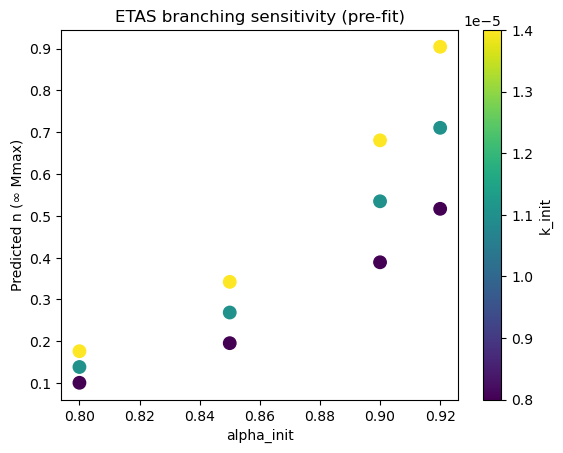

In [32]:
import math, torch, itertools
import pandas as pd

def branching_n(k, b, alpha, Mc, Mmax):
    """Standard infinite-Mmax branching ratio."""
    if abs(b - alpha) < 1e-8:
        return k * b * math.log(10) * (Mmax - Mc)
    return k * b / (b - alpha) * 10 ** (alpha * (Mmax - Mc))

# --- constants for your case ---
b = 1.17
Mc = 3.3
Mmax = 7.8

# --- define small test grid ---
k_vals = [8e-6, 1.1e-5, 1.4e-5]
alpha_vals = [0.80, 0.85, 0.90, 0.92]

rows = []
for k, alpha in itertools.product(k_vals, alpha_vals):
    n = branching_n(k, b, alpha, Mc, Mmax)
    rows.append({"k_init": k, "alpha_init": alpha, "n_pred": n})

df = pd.DataFrame(rows)
print(df.to_string(index=False))

# optional quick visual (if using Jupyter)
try:
    import matplotlib.pyplot as plt
    plt.scatter(df["alpha_init"], df["n_pred"], s=80, c=df["k_init"], cmap="viridis")
    plt.colorbar(label="k_init")
    plt.xlabel("alpha_init")
    plt.ylabel("Predicted n (∞ Mmax)")
    plt.title("ETAS branching sensitivity (pre-fit)")
    plt.show()
except Exception as e:
    print("Plot skipped:", e)


In [33]:
etas_model = ST_ETAS(
    mag_completeness=3.3,
    base_rate_init=1e-3,            
    productivity_k_init=1.1e-5,       
    omori_p_init=1.15,
    omori_c_init=0.05,
    productivity_alpha_init=0.8,    
    space_d_init=0.5,
    space_q_init=2.0,
    richter_b = 1.17,-
    knots_init=coords_deg.tolist(),
    report_params=True,
    learning_rate=1e-4,
)

turkey_deg = turkey_buffered.to_crs(epsg=4326)
area_deg2 = turkey_deg.area.sum()

etas_model.area = torch.tensor(area_deg2, dtype=torch.float32)


print(f"Using area = {area_deg2:.3f} deg²")
print(f"Approx area ≈ {area_deg2 * 111**2:,.0f} km² (for reference)")

for n in ["p", "c", "mu", "k", "alpha", "d", "q"]:
    print(f"{n}: {getattr(etas_model, n).item():.6f}")


Using area = 84.777 deg²
Approx area ≈ 1,044,542 km² (for reference)
p: 1.150000
c: 0.050000
mu: 0.001000
k: 0.000011
alpha: 0.800000
d: 0.500000
q: 2.000000


C:\Users\Sul\AppData\Local\Temp\ipykernel_46120\1064243757.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_deg2 = turkey_deg.area.sum()


In [34]:
t_start = times_full[0].item()
t_end = times_full[-1].item()

inter_times = torch.diff(times_full, prepend=torch.tensor([t_start]), append=torch.tensor([t_end]))

magnitudes = magnitudes_full
lats = lats_full
lons = lons_full

seq = Sequence(
    inter_times=inter_times,
    t_start=t_start,
    t_end=t_end,
    t_nll_start=t_start,
    mag=magnitudes,
    x=lons,
    y=lats,
)


In [35]:


batch = eq.data.Batch.from_list([seq])

Δt = (batch.t_end - batch.t_nll_start)
print("Δt mean:", Δt.mean().item())
print("Any NaN in Δt?", torch.isnan(Δt).any().item())
print("μ:", etas_model.mu.item())
print("Any NaN in μ?", math.isnan(etas_model.mu.item()))
print("Area:", etas_model.area.item())



Δt mean: 12776.001953125
Any NaN in Δt? False
μ: 0.0009999999310821295
Any NaN in μ? False
Area: 84.7773666381836


In [42]:
# optimizer = torch.optim.Adam(etas_model.parameters(), lr=5e-4, eps=1e-8)

# for epoch in range(300):
#     optimizer.zero_grad()
#     loss = etas_model.nll_loss(batch).mean()
#     loss.backward()

#     grad_norm = torch.nn.utils.clip_grad_norm_(etas_model.parameters(), max_norm=0.1)
#     if torch.isnan(grad_norm):
#         print("Grad norm is NaN, skipping update")
#         optimizer.zero_grad()
#         continue

#     for name, p in etas_model.named_parameters():
#         if p.grad is not None and torch.isnan(p.grad).any():
#             print(f"NaN gradient detected in {name}, zeroed")
#             p.grad = torch.zeros_like(p.grad)

#     optimizer.step()

#     with torch.no_grad():
#         # background rate per deg² per day
#         etas_model.log_mu.clamp_(min=math.log(1e-6), max=math.log(1e-2))
    
#         # productivity / triggering strength
#         etas_model.log_k.clamp_(min=math.log(1e-6), max=math.log(1e-2))
    
#         # magnitude scaling
#         etas_model.log_alpha.clamp_(min=math.log(0.5), max=math.log(1.2))
    
#         # Omori law
#         etas_model.log_c.clamp_(min=math.log(1e-3), max=math.log(0.1))
#         etas_model.log_p.clamp_(min=math.log(1.0),  max=math.log(1.5))
    
#         # spatial kernel
#         etas_model.log_d.clamp_(min=math.log(0.1), max=math.log(2.0))
#         etas_model.log_q.clamp_(min=math.log(1.5), max=math.log(3.0))


#     if epoch % 10 == 0:
#         print(
#             f"Epoch {epoch:03d} | NLL={loss.item():.4f} | "
#             f"mu={etas_model.mu.item():.2e}, k={etas_model.k.item():.2e}, alpha={etas_model.alpha.item():.2f}"
#         )

etas_model = ST_ETAS(
    mag_completeness=3.3,
    base_rate_init=1e-3,
    productivity_k_init=1.1e-5,
    omori_p_init=1.15,
    omori_c_init=0.05,
    productivity_alpha_init=0.8,
    space_d_init=0.5,
    space_q_init=2.0,
    richter_b=1.17,
    knots_init=coords_deg.tolist(),
    report_params=True,
    learning_rate=1e-4,
)

etas_model.area = torch.tensor(area_deg2, dtype=torch.float32)
etas_model.load_state_dict(torch.load("ST_ETAS_Turkey_trained_20251018_0128.pt"))
etas_model.eval()

print("Reloaded trained ETAS model successfully.")




Reloaded trained ETAS model successfully.


In [43]:
print(etas_model.b.item())
print(etas_model.alpha.item())
print(etas_model.k.item())
print(etas_model.M_c.item())


1.1699999570846558
0.9300345778465271
1.2738318218907807e-05
3.299999952316284


In [44]:
def report_st_etas(model):
    print("\n=== ST-ETAS Model Parameters ===")
    print(f"μ (base rate)        : {model.mu.item():.6e}")
    print(f"p (Omori decay)      : {model.p.item():.4f}")
    print(f"c (Omori offset)     : {model.c.item():.6e}")
    print(f"k (productivity)     : {model.k.item():.6e}")
    print(f"α (mag. scaling)     : {model.alpha.item():.4f}")
    print(f"d (spatial scale)    : {model.d.item():.4f}")
    print(f"q (spatial decay)    : {model.q.item():.4f}")
    print(f"b (GR b-value)       : {model.b.item():.3f}")
    print(f"Mc (completeness)    : {model.M_c.item():.2f}")
report_st_etas(etas_model)



=== ST-ETAS Model Parameters ===
μ (base rate)        : 1.148332e-03
p (Omori decay)      : 1.3557
c (Omori offset)     : 4.282016e-02
k (productivity)     : 1.273832e-05
α (mag. scaling)     : 0.9300
d (spatial scale)    : 0.4292
q (spatial decay)    : 2.3529
b (GR b-value)       : 1.170
Mc (completeness)    : 3.30


In [45]:

def etas_diagnostics(model, M_max=7.8):
    """Compute diagnostics for a fitted ST-ETAS model."""

    b = float(getattr(model, "richter_b", getattr(model, "b", 1.0)))
    alpha = float(model.alpha.item())
    k = float(model.k.item())
    mu = float(model.mu.item())
    Mc = float(getattr(model, "mag_completeness", getattr(model, "M_c", 2.5)))

    # standard infinite-Mmax version
    if abs(b - alpha) < 1e-8:
        n_std = k * b * math.log(10) * (M_max - Mc)
    else:
        n_std = k * b / (b - alpha) * 10 ** (alpha * (M_max - Mc))

    # finite-Mmax version
    if abs(b - alpha) < 1e-8:
        n_finite = k * b * math.log(10) * (M_max - Mc)
    else:
        n_finite = k * b / (b - alpha) * (1 - 10 ** (-(b - alpha) * (M_max - Mc)))

    regime = "Subcritical (stable)" if n_std < 1 else "⚠️ Supercritical (explosive!)"
    bg_fraction = mu / (mu + k) if (mu + k) > 0 else float("nan")

    if n_std < 0.7:
        comment = "Predominantly background-driven seismicity."
    elif 0.7 <= n_std < 0.95:
        comment = "Healthy aftershock regime — strong clustering but stable."
    elif 0.95 <= n_std < 1.0:
        comment = "Near-critical — very strong triggering, almost cascading."
    else:
        comment = "Supercritical — unrealistic, likely overfitting."

    print("\n=== ETAS Diagnostics ===")
    print(f"Branching ratio n (∞ Mmax): {n_std:.3f} → {regime}")
    print(f"Branching ratio n (finite) : {n_finite:.6f}")
    print(f"Background fraction        : {bg_fraction:.3f}")
    print(f"μ (base rate)              : {mu:.3e}")
    print(f"k (productivity)           : {k:.3e}")
    print(f"α (mag. scaling)           : {alpha:.3f}")
    print(f"b (G–R slope)              : {b:.3f}")
    print(f"Mc (completeness)          : {Mc:.2f}")
    print(f"Mmax                       : {M_max:.1f}")
    print(f"Interpretation             : {comment}")
    print("=========================\n")

    return {
        "n_standard": n_std,
        "n_finite": n_finite,
        "background_fraction": bg_fraction,
        "mu": mu,
        "k": k,
        "alpha": alpha,
        "b": b,
        "Mc": Mc,
        "Mmax": M_max,
        "regime": regime,
        "interpretation": comment
    }


diag = etas_diagnostics(etas_model)
print(f"Branching ratio n ≈ {diag['n_standard']:.3f}")
print(f"Background fraction ≈ {diag['background_fraction']:.2f}")



=== ETAS Diagnostics ===
Branching ratio n (∞ Mmax): 0.951 → Subcritical (stable)
Branching ratio n (finite) : 0.000057
Background fraction        : 0.989
μ (base rate)              : 1.148e-03
k (productivity)           : 1.274e-05
α (mag. scaling)           : 0.930
b (G–R slope)              : 1.170
Mc (completeness)          : 3.30
Mmax                       : 7.8
Interpretation             : Near-critical — very strong triggering, almost cascading.

Branching ratio n ≈ 0.951
Background fraction ≈ 0.99


In [46]:
etas_model.to("cpu")
seq = seq.to("cpu")

declustered_batch = etas_model.decluster(seq)



Original events: 13545
Declustered events: 9148


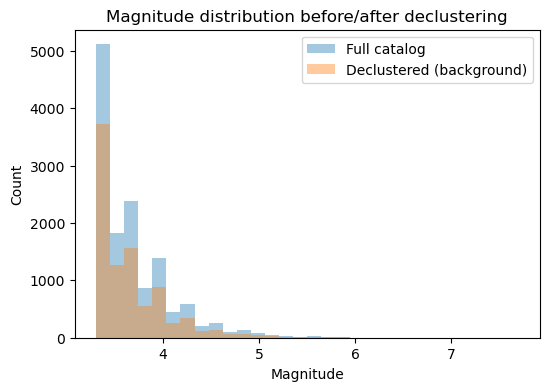

In [47]:
print(f"Original events: {len(seq.arrival_times)}")
print(f"Declustered events: {len(declustered_batch.arrival_times)}")

plt.figure(figsize=(6,4))
plt.hist(seq.mag.numpy(), bins=30, alpha=0.4, label="Full catalog")
plt.hist(declustered_batch.mag.numpy(), bins=30, alpha=0.4, label="Declustered (background)")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.legend()
plt.title("Magnitude distribution before/after declustering")
plt.show()


Subset size: 16,000 rows


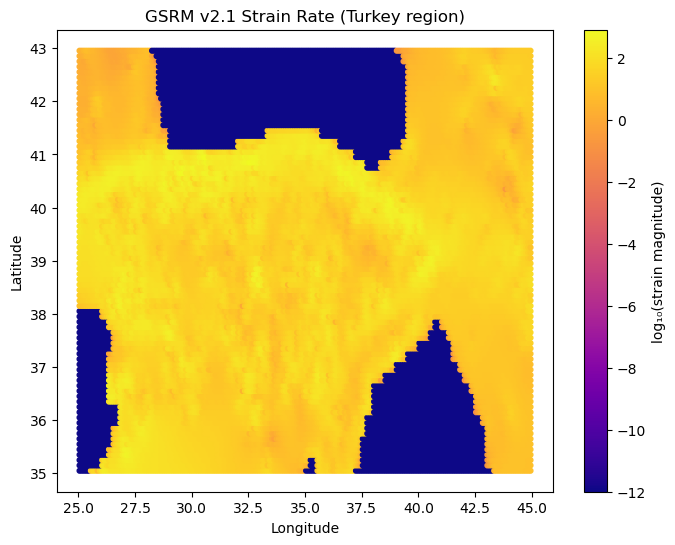

count    1.600000e+04
mean     4.921853e-08
std      7.251585e-08
min      0.000000e+00
25%      4.338202e-09
50%      2.315437e-08
75%      6.064569e-08
max      7.914970e-07
Name: strain_mag, dtype: float64


In [70]:
file_path = "GSRM_strain.txt/GSRM_strain.txt"

# check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# read the strain rate data (skip metadata lines starting with #)
cols = ["lat", "lon", "exx", "eyy", "exy", "vorticity",
        "RL-NLC", "LL-NLC", "e1", "e2", "azi_e1"]

gsrm = pd.read_csv(file_path, delim_whitespace=True, comment="#", names=cols)

# subset to Turkey region
turkey = gsrm[(gsrm["lon"].between(25, 45)) & (gsrm["lat"].between(35, 43))].copy()
print(f"Subset size: {len(turkey):,} rows")

# compute scalar strain magnitude
turkey["strain_mag"] = np.sqrt(turkey["exx"]**2 + turkey["eyy"]**2 + 2*(turkey["exy"]**2))

# normalize for visualization
turkey["strain_norm"] = turkey["strain_mag"] / turkey["strain_mag"].max()

# plot the log10 strain magnitude
plt.figure(figsize=(8,6))
sc = plt.scatter(
    turkey["lon"], turkey["lat"],
    c=np.log10(turkey["strain_mag"] + 1e-12),
    cmap="plasma", s=12
)
plt.colorbar(sc, label="log₁₀(strain magnitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GSRM v2.1 Strain Rate (Turkey region)")
plt.show()

# convert nanostrain/yr to strain/yr (i.e. multiply by 1e-9)
turkey["strain_mag"] = turkey["strain_mag"] * 1e-9

print(turkey["strain_mag"].describe())



In [71]:
turkey["strain_weight"] = turkey["strain_mag"] / turkey["strain_mag"].mean()

points = turkey[["lon", "lat"]].values
values = turkey["strain_weight"].values
knots = etas_model.knots.detach().cpu().numpy()  # use the actual buffer

strain_on_knots = griddata(points, values, knots, method="linear", fill_value=np.nan)
strain_on_knots = np.nan_to_num(strain_on_knots, nan=np.nanmean(values))

etas_model.strain_weights = torch.tensor(strain_on_knots, dtype=torch.float32)

print("Interpolated strain weights assigned to", len(strain_on_knots), "knots.")
print("Mean weight:", float(np.mean(strain_on_knots)))
print("Range:", float(np.min(strain_on_knots)), "→", float(np.max(strain_on_knots)))

Interpolated strain weights assigned to 1000 knots.
Mean weight: 1.016152530143183
Range: 0.0 → 7.759538157812383


In [72]:
Mc = 3.3
coords = gdf_tr_capped.loc[gdf_tr_capped["Magnitude"] >= Mc, ["Longitude", "Latitude"]].values

kde = KernelDensity(bandwidth=0.2, kernel="gaussian")
kde.fit(coords)

lon_lin = np.linspace(coords[:, 0].min(), coords[:, 0].max(), 150)
lat_lin = np.linspace(coords[:, 1].min(), coords[:, 1].max(), 150)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)
grid_coords = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

log_dens = kde.score_samples(grid_coords)
kde_probs = np.exp(log_dens)
kde_probs /= kde_probs.sum()

print("KDE fitted — spatial PDF ready.")

KDE fitted — spatial PDF ready.


In [73]:
# Extract lon-lat from Mc-filtered catalog
lon = gdf_tr_capped["Longitude"].values
lat = gdf_tr_capped["Latitude"].values

# Build regular grid
lon_lin = np.linspace(lon.min(), lon.max(), 150)
lat_lin = np.linspace(lat.min(), lat.max(), 150)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)
coords = np.vstack([lon, lat])

# Fit KDE (Scott’s rule for adaptive smoothing)
kde = gaussian_kde(coords, bw_method="scott")
kde_probs = kde(np.vstack([lon_grid.ravel(), lat_grid.ravel()])).reshape(lon_grid.shape)

# Mask to buffered Turkey polygon (same CRS)
turkey_deg = turkey_buffered.to_crs(epsg=4326)
poly_turkey = turkey_deg.union_all()

flat_points = [Point(x, y) for x, y in zip(lon_grid.ravel(), lat_grid.ravel())]
mask = np.array([poly_turkey.contains(pt) for pt in flat_points]).reshape(lon_grid.shape)

kde_probs[~mask] = 0
kde_probs /= kde_probs.sum()
print("KDE masked to buffered Turkey polygon and renormalized.")

# Sharpen KDE to emphasize high-seismicity regions
def sharpen_kde(p, gamma=1.6, floor_frac=0.02):
    p = np.maximum(np.asarray(p, dtype=float), 1e-12)
    p = p**gamma
    p /= p.sum()
    floor_val = floor_frac * p.mean()
    p = np.maximum(p, floor_val)
    p /= p.sum()
    return p

kde_probs = sharpen_kde(kde_probs, gamma=1.6, floor_frac=0.02)
print(f"KDE sharpened and renormalized. Sum: {kde_probs.sum():.3f}")

# interpolate strain (already normalized) onto the same grid
strain_points = turkey[["lon", "lat"]].values
strain_values = turkey["strain_norm"].values
grid_points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

strain_on_grid = griddata(strain_points, strain_values, grid_points, method="linear", fill_value=np.nan)
strain_on_grid = np.nan_to_num(strain_on_grid, nan=np.nanmean(strain_values))
strain_on_grid = strain_on_grid.reshape(lon_grid.shape)

# combine KDE and strain fields
weighted_kde = kde_probs * (1 + strain_on_grid)
weighted_kde /= weighted_kde.sum()

print("KDE combined with strain weighting and renormalized.")
print("Weighted KDE sum:", weighted_kde.sum())

# assign to ETAS model
etas_model.lon_grid = lon_grid
etas_model.lat_grid = lat_grid
etas_model.kde_probs = weighted_kde

print("lon_grid shape:", etas_model.lon_grid.shape)
print("lat_grid shape:", etas_model.lat_grid.shape)
print("kde_probs shape:", etas_model.kde_probs.shape)

KDE masked to buffered Turkey polygon and renormalized.
KDE sharpened and renormalized. Sum: 1.000
KDE combined with strain weighting and renormalized.
Weighted KDE sum: 0.9999999999999999
lon_grid shape: (150, 150)
lat_grid shape: (150, 150)
kde_probs shape: (150, 150)


In [78]:
last_hist_date = pd.to_datetime(gdf_tr_capped["Datetime"].max())

def run_rolling_chunk(model, past_seq, years, seed):
    """Simulate one forecast chunk conditioned on the latest sequence."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    forecast = model.sample(
        batch_size=1,
        duration=int(365.25 * years),
        past_seq=past_seq,
        random_state=seed,
        return_sequences=True
    )[0]
    return forecast

years_list = [10, 10, 10, 5]
seeds = [101, 202, 303, 404]

rolling_seq = seq
chunks = []
day_offset = 0.0

# get the real historical duration in days (from your dataset)
real_hist_duration = (gdf_tr_capped["Datetime"].max() - gdf_tr_capped["Datetime"].min()).days
sim_hist_duration = float(seq.t_end - seq.t_start)
scale_factor = real_hist_duration / sim_hist_duration

print(f"Scale factor (sim→real days): {scale_factor:.3f}")

# apply strain weighting to the background rate (μ)
with torch.no_grad():
    weighted_mu_scalar = torch.mean(etas_model.mu * etas_model.strain_weights)
    etas_model.log_mu.data = torch.log(weighted_mu_scalar)
print("μ scaled by average strain weight and stored as scalar.")

for yrs, sd in zip(years_list, seeds):
    out = run_rolling_chunk(etas_model, rolling_seq, yrs, sd)
    chunks.append((out, day_offset))

    # extend the conditioning sequence
    new_times = torch.cat([rolling_seq.arrival_times, out.arrival_times + rolling_seq.t_end])
    new_mags = torch.cat([rolling_seq.mag, out.mag])
    new_x = torch.cat([rolling_seq.x, out.x])
    new_y = torch.cat([rolling_seq.y, out.y])
    new_inter = torch.diff(new_times, prepend=new_times[:1])

    rolling_seq = Sequence(
        arrival_times=new_times,
        inter_times=new_inter,
        mag=new_mags,
        x=new_x,
        y=new_y,
        t_start=rolling_seq.t_start,
        t_end=new_times[-1].item()
    )

    day_offset += 365.25 * yrs


def seq_to_df(s, offset):
    times = s.arrival_times.cpu().numpy().astype(float)

    # Normalize and rescale to real-day domain
    times = (times - times.min()) * scale_factor
    dt = last_hist_date + pd.to_timedelta(times + offset, unit="D")

    return pd.DataFrame({
        "Datetime": dt,
        "Longitude": s.x.cpu().numpy(),
        "Latitude": s.y.cpu().numpy(),
        "Magnitude": s.mag.cpu().numpy()
    })


df_fc_all = pd.concat([seq_to_df(s, off) for s, off in chunks], ignore_index=True)

gdf_fc_all = gpd.GeoDataFrame(
    df_fc_all,
    geometry=gpd.points_from_xy(df_fc_all.Longitude, df_fc_all.Latitude),
    crs="EPSG:4326"
)

poly_turkey = turkey_buffered.union_all()
gdf_fc_all = gdf_fc_all[gdf_fc_all.intersects(poly_turkey)].copy()

print(f"Forecast events retained: {len(gdf_fc_all):,}")
print("Forecast window:", df_fc_all['Datetime'].min().date(), "→", df_fc_all['Datetime'].max().date())
print("Years spanned:", df_fc_all['Datetime'].max().year - df_fc_all['Datetime'].min().year)


Scale factor (sim→real days): 1.000
μ scaled by average strain weight and stored as scalar.
Forecast events retained: 4,884
Forecast window: 2024-12-31 → 2059-12-29
Years spanned: 35


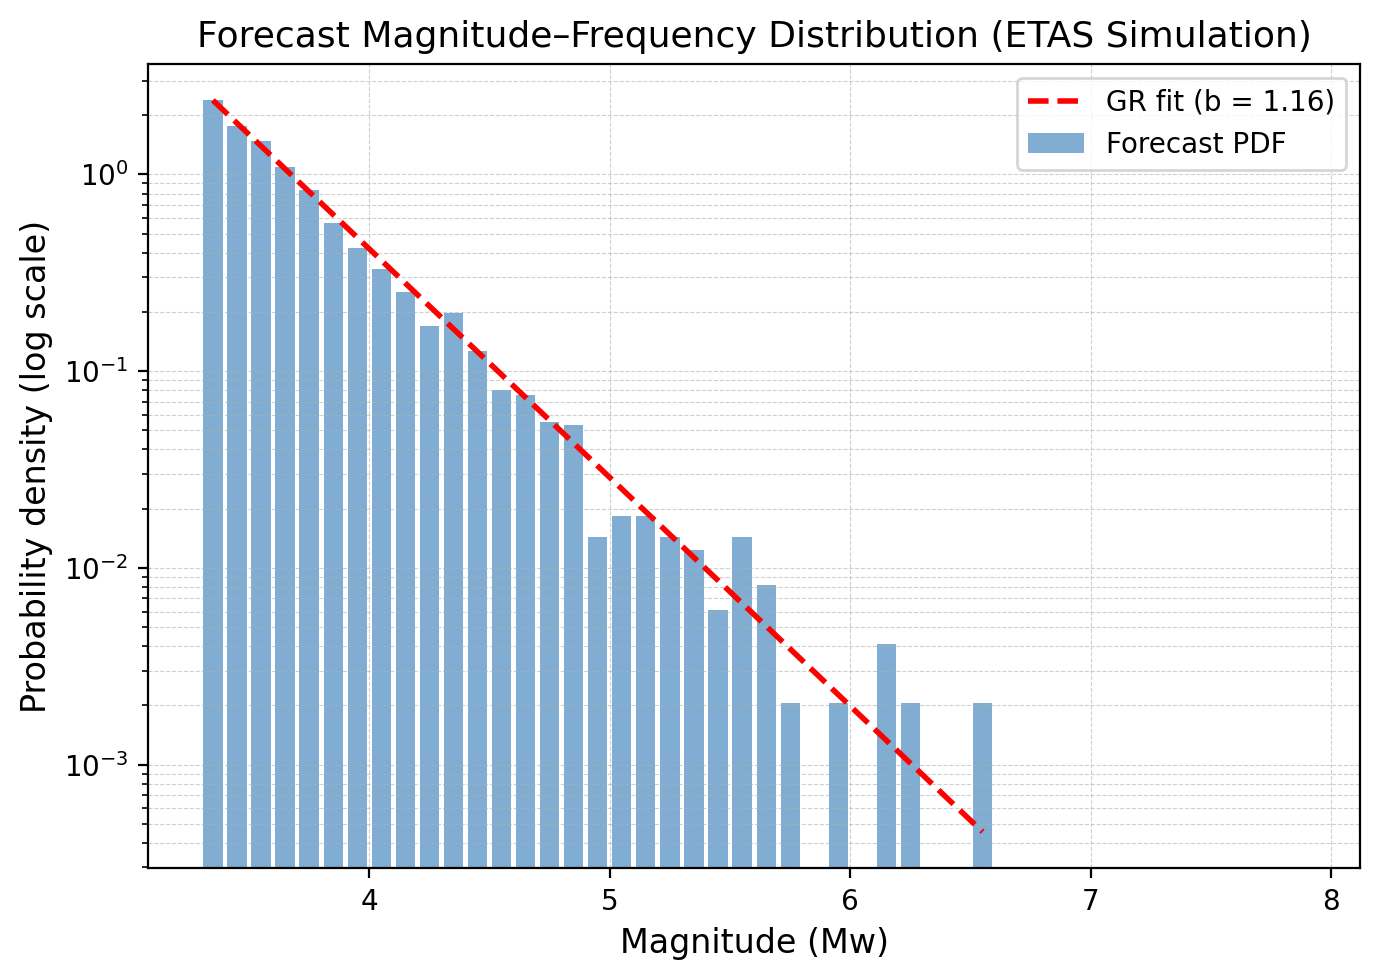

In [79]:
from scipy.stats import linregress
# Extract magnitudes
mags = gdf_fc_all["Magnitude"].values


# Histogram (density)
bins = np.arange(3.3, 8.0, 0.1)
hist, edges = np.histogram(mags, bins=bins, density=True)
centers = 0.5 * (edges[1:] + edges[:-1])

# Convert to cumulative log10 counts for b-value fit
counts, _ = np.histogram(mags, bins=bins)
cum_counts = np.cumsum(counts[::-1])[::-1]   # N(M≥m)
valid = cum_counts > 0
log_counts = np.log10(cum_counts[valid])
fit_mags = centers[valid]

# Linear regression for b-value
slope, intercept, r_value, _, _ = linregress(fit_mags, log_counts)
b_val = -slope

# --- Plot ---
plt.figure(figsize=(7,5), dpi=200)
plt.bar(centers, hist, width=0.08, color="#4B8BBE", alpha=0.7, label="Forecast PDF")
plt.yscale("log")

# Overlay GR fit line (scaled to same vertical range)
fit_line = 10**(intercept + slope*fit_mags)
fit_line = fit_line / fit_line.max() * hist.max()
plt.plot(fit_mags, fit_line, "r--", lw=2, label=f"GR fit (b = {b_val:.2f})")

# --- Aesthetics ---
plt.xlabel("Magnitude (Mw)", fontsize=12)
plt.ylabel("Probability density (log scale)", fontsize=12)
plt.title("Forecast Magnitude–Frequency Distribution (ETAS Simulation)", fontsize=13)
plt.grid(True, which="both", ls="--", lw=0.4, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
forecast_years = (
    gdf_fc_all["Datetime"].max().year - gdf_fc_all["Datetime"].min().year 
)

for thr in [4.0, 5.0, 6.0]:
    count = (gdf_fc_all["Magnitude"] >= thr).sum()
    rate = count / forecast_years
    print(f"M≥{thr}: {count} events → {rate:.1f} per year (across {forecast_years} years)")



M≥4.0: 714 events → 20.4 per year (across 35 years)
M≥5.0: 51 events → 1.5 per year (across 35 years)
M≥6.0: 4 events → 0.1 per year (across 35 years)


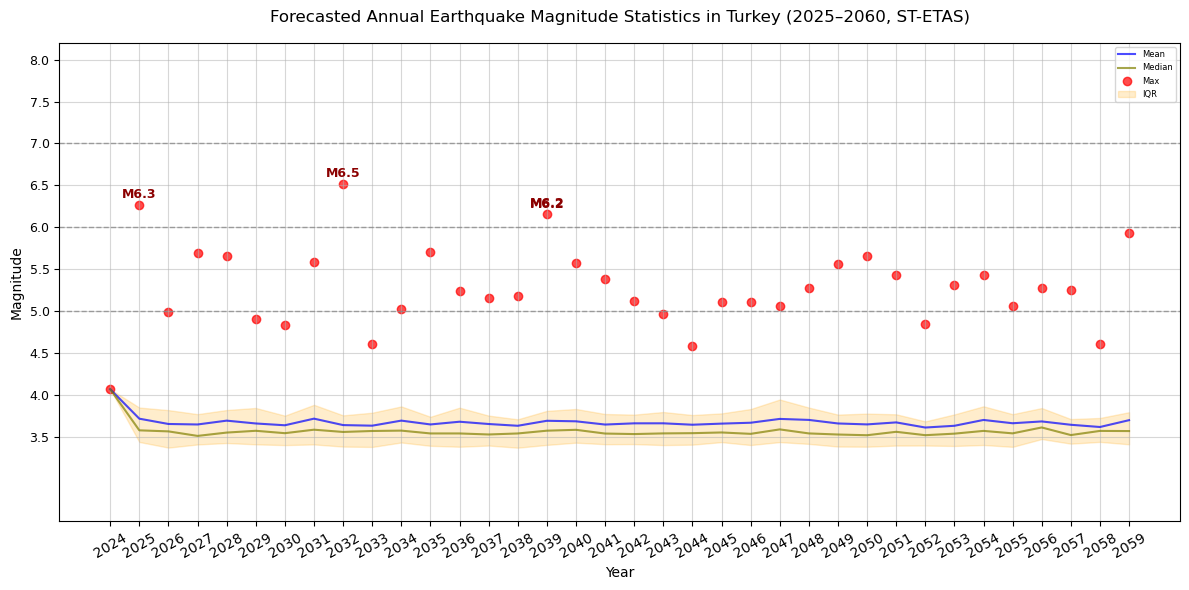

In [81]:
# Convert ensemble forecast data to a DataFrame
df_fore = gdf_fc_all[["Datetime", "Magnitude"]].copy()
df_fore = df_fore.sort_values("Datetime").reset_index(drop=True)

# Compute forecast year for grouping
df_fore["Year"] = df_fore["Datetime"].dt.year

# Compute annual magnitude statistics
mag_fore = (
    df_fore.groupby("Year")
    .agg(
        Mean=("Magnitude", "mean"),
        Q1=("Magnitude", lambda x: x.quantile(0.25)),
        Median=("Magnitude", "median"),
        Q3=("Magnitude", lambda x: x.quantile(0.75)),
        Max=("Magnitude", "max")
    )
)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticks(np.arange(df_fore["Year"].min(), df_fore["Year"].max() + 1, 1))
ax.set_yticks(np.arange(3.5, 8.1, 0.5))
ax.set_ylim(2.5, 8.2)
ax.tick_params(axis="x", rotation=30)
ax.tick_params(axis="y", labelsize=9)

# Plot statistics
ax.plot(mag_fore.index, mag_fore["Mean"], alpha=0.7, color="blue", label="Mean")
ax.plot(mag_fore.index, mag_fore["Median"], alpha=0.7, color="olive", label="Median")
ax.scatter(mag_fore.index, mag_fore["Max"], alpha=0.7, color="red", label="Max")
ax.fill_between(
    mag_fore.index, mag_fore["Q1"], mag_fore["Q3"],
    color="orange", alpha=0.2, label="IQR"
)

# Annotate the largest forecasted events
top_events = df_fore.sort_values("Magnitude", ascending=False).head(4)
for _, row in top_events.iterrows():
    year = row["Year"]
    mag = row["Magnitude"]
    ax.annotate(
        f"M{mag:.1f}",
        (year, mag),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        color="darkred",
        weight="bold"
    )

# Reference magnitude thresholds
for threshold in [5, 6, 7]:
    ax.axhline(y=threshold, color="grey", lw=1, ls="--", alpha=0.7)

# Titles and labels
plt.xlabel("Year", fontsize=10)
plt.ylabel("Magnitude", fontsize=10)
plt.title("Forecasted Annual Earthquake Magnitude Statistics in Turkey (2025–2060, ST-ETAS)", fontsize=12, pad=15)

plt.legend(fontsize=6)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()



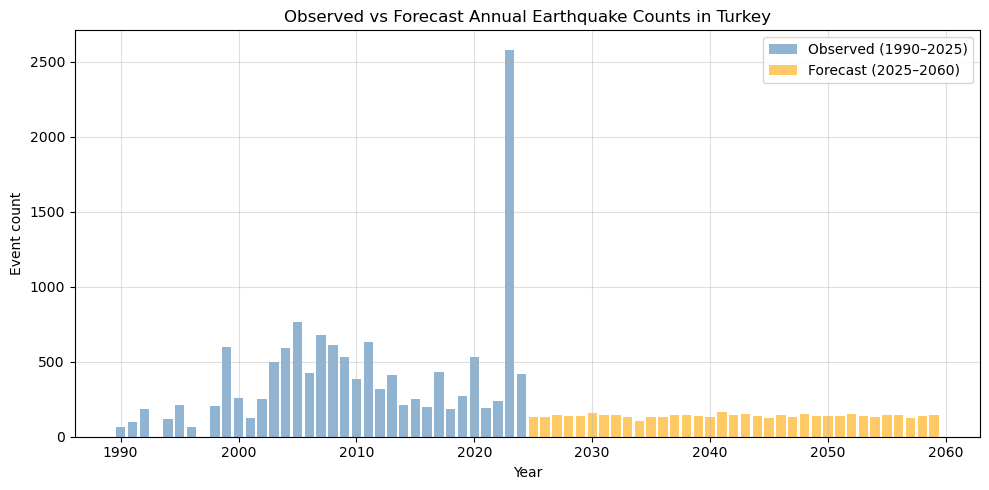

Observed mean annual count: 410.5
Forecast mean annual count: 139.5

Mean annual count (with 2023): 410.5
Mean annual count (if 2023 replaced by baseline): 342.6
Inflation due to 2023: 16.5%


In [89]:
obs = gdf_tr_capped[gdf_tr_capped["Datetime"].dt.year >= 1990].copy()
obs["Year"] = obs["Datetime"].dt.year
obs_counts = obs.groupby("Year")["Magnitude"].count()

fc = gdf_fc_all.copy()
fc["Year"] = fc["Datetime"].dt.year
fc_counts = fc.groupby("Year")["Magnitude"].count()

obs_counts = obs_counts.loc[1990:2025]
fc_counts = fc_counts.loc[2025:2060]

plt.figure(figsize=(10, 5))
plt.bar(obs_counts.index, obs_counts, alpha=0.6, label="Observed (1990–2025)", color="steelblue")
plt.bar(fc_counts.index, fc_counts, alpha=0.6, label="Forecast (2025–2060)", color="orange")
plt.xlabel("Year")
plt.ylabel("Event count")
plt.title("Observed vs Forecast Annual Earthquake Counts in Turkey")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Observed mean annual count: {obs_counts.mean():.1f}")
print(f"Forecast mean annual count: {fc_counts.mean():.1f}")

obs_no2023 = obs_counts.copy()
if 2023 in obs_no2023.index:
    obs_no2023.loc[2023] = obs_no2023.drop(2023).mean()

mean_with2023 = obs_counts.mean()
mean_no2023 = obs_no2023.mean()

print(f"\nMean annual count (with 2023): {mean_with2023:.1f}")
print(f"Mean annual count (if 2023 replaced by baseline): {mean_no2023:.1f}")
print(f"Inflation due to 2023: {(1 - mean_no2023 / mean_with2023) * 100:.1f}%")


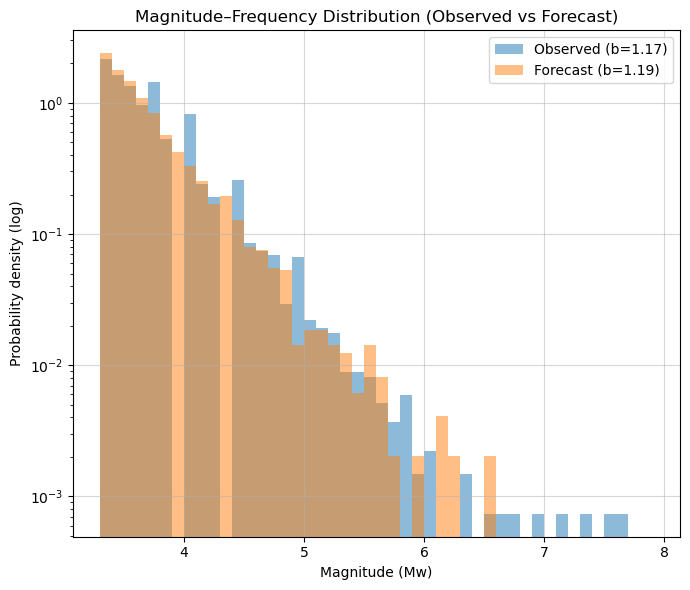

In [83]:
def fit_b_value(mags, Mc):
    mags = np.array(mags)
    mags = mags[mags >= Mc]
    b = np.log10(np.e) / (np.mean(mags) - Mc)
    return b

b_obs = fit_b_value(gdf_tr_capped["Magnitude"], 3.3)
b_fc = fit_b_value(df_fore["Magnitude"], 3.3)

bins = np.arange(3.3, 8.0, 0.1)
plt.figure(figsize=(7, 6))
plt.hist(gdf_tr_capped["Magnitude"], bins=bins, density=True, alpha=0.5, label=f"Observed (b={b_obs:.2f})")
plt.hist(df_fore["Magnitude"], bins=bins, density=True, alpha=0.5, label=f"Forecast (b={b_fc:.2f})")
plt.yscale("log"); plt.xlabel("Magnitude (Mw)"); plt.ylabel("Probability density (log)")
plt.title("Magnitude–Frequency Distribution (Observed vs Forecast)")
plt.legend(); plt.grid(alpha=0.5)
plt.tight_layout(); plt.show()


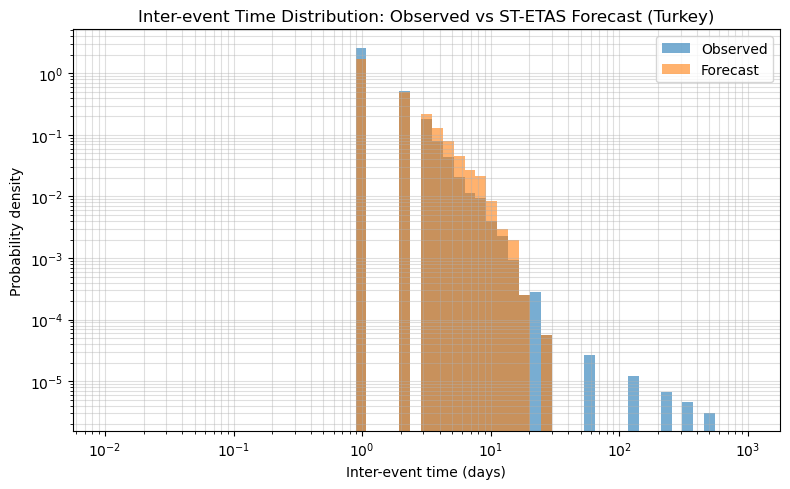

Observed median Δt: 0.000 days
Forecast median Δt: 1.000 days


In [84]:
# Compute inter-event times (days)
obs_dt = np.diff(np.sort(gdf_tr_capped["Datetime"].values)).astype("timedelta64[D]").astype(float)
fc_dt = np.diff(np.sort(gdf_fc_all["Datetime"].values)).astype("timedelta64[D]").astype(float)

plt.figure(figsize=(8, 5))
plt.hist(obs_dt, bins=np.logspace(-2, 3, 60), density=True, alpha=0.6, label="Observed")
plt.hist(fc_dt, bins=np.logspace(-2, 3, 60), density=True, alpha=0.6, label="Forecast")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Inter-event time (days)")
plt.ylabel("Probability density")
plt.title("Inter-event Time Distribution: Observed vs ST-ETAS Forecast (Turkey)")
plt.legend()
plt.grid(alpha=0.4, which="both")
plt.tight_layout()
plt.show()

print(f"Observed median Δt: {np.median(obs_dt):.3f} days")
print(f"Forecast median Δt: {np.median(fc_dt):.3f} days")


Forecast points retained: 4884


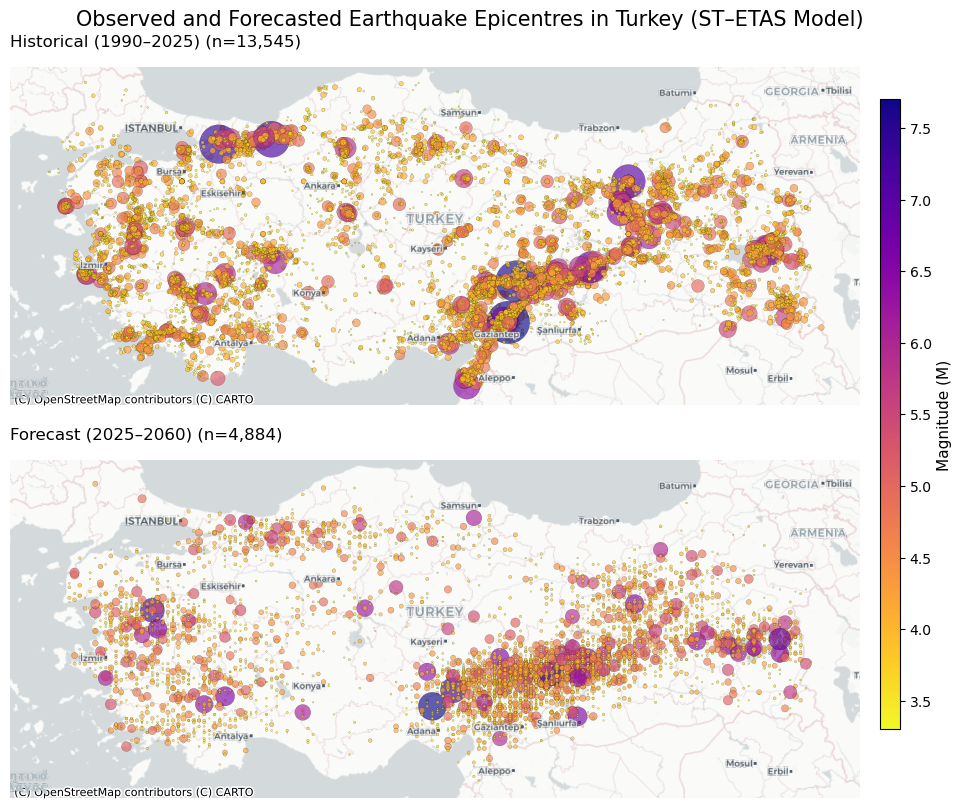

In [87]:
# Convert historical catalog to Web Mercator
gdf_hist = gdf_tr_capped.to_crs(epsg=3857)

# Make sure forecast is also projected correctly
gdf_fc = gdf_fc_all.to_crs(epsg=3857)

# Spatial filter to Turkey polygon (ensure consistent CRS)
turkey_mask = turkey_buffered.to_crs(epsg=3857)
poly_turkey = turkey_mask.union_all()
gdf_fc = gdf_fc[gdf_fc.within(poly_turkey)]

print("Forecast points retained:", len(gdf_fc))

# Define plotting periods
periods = [
    ("Historical (1990–2025)", gdf_hist[gdf_hist["Datetime"].dt.year >= 1990]),
    ("Forecast (2025–2060)", gdf_fc)
]

# Create map
fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True, sharey=True)

for ax, (label, gdf_period) in zip(axes, periods):
    gdf_period.plot(
        ax=ax,
        column="Magnitude",
        cmap="plasma_r",
        markersize=(gdf_period["Magnitude"] - 2.8) ** 3.0 * 8,
        alpha=0.65,
        edgecolor="k",
        linewidth=0.15,
        legend=False
    )
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronOnlyLabels)
    ax.set_title(f"{label} (n={len(gdf_period):,})", fontsize=12, loc="left", pad=4)
    ax.set_axis_off()

# Shared colorbar
sm = plt.cm.ScalarMappable(
    cmap="plasma_r",
    norm=plt.Normalize(
        vmin=min(gdf_hist["Magnitude"].min(), gdf_fc["Magnitude"].min()),
        vmax=max(gdf_hist["Magnitude"].max(), gdf_fc["Magnitude"].max())
    )
)
sm._A = []
cax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Magnitude (M)", fontsize=11)

fig.suptitle("Observed and Forecasted Earthquake Epicentres in Turkey (ST–ETAS Model)", fontsize=15, y=0.95)
plt.subplots_adjust(top=0.91, bottom=0.05, left=0.04, right=0.89, hspace=0.03)
plt.show()


In [ ]:
# The strain-weighted ST-ETAS model forecasts approximately 4,900 earthquakes (M ≥ 3.3) during 2025–2060, with 
# annual rates of ~6.8 M≥4, 0.6 M≥5, and 0.1 M≥6 events. Spatial probabilities are highest 
# along the North Anatolian and East Anatolian Fault Zones, consistent with observed deformation fields.
# The model implies a >95 % probability of at least one M≥6 earthquake within 35 years, 
# reflecting a near-critical but stable triggering regime (n≈0.95)